<h1><center>Predict Telecom Churn</center></h1>

## Introduction

As part of this Analyis, High Value customer behaviour will be studied to predict the probability of the churn.
The analysis follows the CRISP-DM standard methodology of - Defining Goal, Cleaning Data , Analysing the data, Training model and Predict the churn possibility. 
The following are assumptions and scope of the study :  
 - The Analysis is based on 4 months of data. The first two month is classifeid as 'Good' period where customer is happy with services, the next month is classified as 'Active' period where customer looks out for alternatives and last month is classified as 'Churn' period where customer do not use any service.
 - The Analysis is based on Usage Based Churn. If the usage of services is 0 in the churn period, then the customer is considerd as churned.
 - The High Value Customers are those who have recharge amount (Voice and Data services) greater than or equal to  the 70th percentile of the average recharge amount in the first two months.

Following is the flow of Analysis :  
- Stage 1 - Identify the High Value Cusotmers. Among them, identify the Customers with no service usage in last month
- Stage 2 - Apply standard Data Cleaning techniques, Treat Outliers , Derive Features as applicable
- Stage 3 - EDA - Data Visualisation and Inferences
- Stage 4 - Apply Dimensionality Reduction (PCA) and Balance the classes as appropriate
- Stage 5 - Train ML models and derive the associated metrics
- Stage 6 - Derive the prominent features 
- Stage 7 - Metric and Model Selection 
- Stage 8 - Conclusion

In [1]:
# Data Handling
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import re

# Visualization
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from palettable.colorbrewer.qualitative import Pastel1_7


# Data pre-processing - Class Balancing and Scaling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Feature Dimension Engineering
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import statsmodels.api as sm
from xgboost import XGBClassifier

# Model Tuning 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Calculate Metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score,roc_curve,scorer,precision_recall_curve 
from sklearn import metrics
from scipy.stats import norm

# Set the session options
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Read data into Dataframe
custdata=pd.read_csv('telecom_churn_data.csv')

In [3]:
# Get a feel of data
custdata.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,nan,4.13,nan,nan,nan,1.15,nan,nan,nan,5.44,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,5.44,0.00,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,na

In [4]:
# Check Data Dimensions, data types and the NaN distribution
print(custdata.shape)
print('\n ---- Null Values ---- ')
print(custdata.isnull().sum(axis=0).sort_values(ascending=False))

(99999, 226)

 ---- Null Values ---- 
count_rech_2g_6             74846
date_of_last_rech_data_6    74846
count_rech_3g_6             74846
av_rech_amt_data_6          74846
max_rech_data_6             74846
total_rech_data_6           74846
arpu_3g_6                   74846
arpu_2g_6                   74846
night_pck_user_6            74846
fb_user_6                   74846
arpu_3g_7                   74428
count_rech_2g_7             74428
fb_user_7                   74428
count_rech_3g_7             74428
arpu_2g_7                   74428
av_rech_amt_data_7          74428
max_rech_data_7             74428
night_pck_user_7            74428
total_rech_data_7           74428
date_of_last_rech_data_7    74428
night_pck_user_9            74077
date_of_last_rech_data_9    74077
fb_user_9                   74077
arpu_2g_9                   74077
max_rech_data_9             74077
arpu_3g_9                   74077
total_rech_data_9           74077
av_rech_amt_data_9          74077
count_rech

### Stage - 1 - Identify High Value Customers and assign Churn label as applicable

In [5]:
# Sanity check for average and total data recharge features
cols=custdata.columns
av_reg=re.compile(r'av_rech_amt_data_*')
tot_reg=re.compile(r'total_rech_data_*')
data_rech_cols=list(filter(av_reg.match,cols))+list(filter(tot_reg.match,cols))
custdata[data_rech_cols].isnull().sum(axis=0).sort_values(ascending=False)

total_rech_data_6     74846
av_rech_amt_data_6    74846
total_rech_data_7     74428
av_rech_amt_data_7    74428
total_rech_data_9     74077
av_rech_amt_data_9    74077
total_rech_data_8     73660
av_rech_amt_data_8    73660
dtype: int64

In [6]:
# As there are lot of NaNs, dropping rows is not correct method. 
#Imput NaNs with 0s and then caluclate the total recharge value for 'Good' months.
custdata[data_rech_cols]=custdata[data_rech_cols].fillna(0)
custdata['total_data_rech_amt_6']=custdata['av_rech_amt_data_6']*custdata['total_rech_data_6']
custdata['total_data_rech_amt_7']=custdata['av_rech_amt_data_7']*custdata['total_rech_data_7']

# Identify the high value customers. Any customers who have recharged more than or equal to 70 perctile of the grand recharge average of good months ( month 6 and 7)
custdata['avg_good_month_rech_amt']=(custdata['total_rech_amt_6']+custdata['total_rech_amt_7']+custdata['total_data_rech_amt_6']+custdata['total_data_rech_amt_7'])/2
custdata['high_value_cust']=np.where(custdata['avg_good_month_rech_amt']>np.percentile(custdata['avg_good_month_rech_amt'],70),'Y','N')
print('70th percentile of the grand average of good months:  ' + str(np.percentile(custdata['avg_good_month_rech_amt'],70))+'\n')

# Count of High Value Customers
print('High value Customers: ',"\n", custdata.groupby(['high_value_cust'])['mobile_number'].count(),"\n")

# Copy  the High Value customers
hv_custdata=custdata[custdata['high_value_cust']=='Y']

70th percentile of the grand average of good months:  478.0

High value Customers:  
 high_value_cust
N    70046
Y    29953
Name: mobile_number, dtype: int64 



In [7]:
# Count of churn Customers
hv_custdata['churn']=np.where(((hv_custdata['total_ic_mou_9']==0) & 
                             (hv_custdata['total_og_mou_9']==0) &
                             (hv_custdata['vol_2g_mb_9']==0) & 
                             (hv_custdata['vol_3g_mb_9']==0)),1,0)


print('Churn Customers in High Value Customers',"\n", hv_custdata[hv_custdata['high_value_cust']=='Y'].groupby(['churn'])['mobile_number'].count())

# Drop the columns related to churn month
cols=hv_custdata.columns
churn_reg=re.compile(r'.*_9')
churn_cols=list(filter(churn_reg.match,cols))
churn_cols=churn_cols+['sep_vbc_3g']
hv_custdata.drop(columns=churn_cols,axis=1,inplace=True)


Churn Customers in High Value Customers 
 churn
0    27520
1     2433
Name: mobile_number, dtype: int64


### Stage - 2 - Apply standard Data Cleaning techniques, Treat Outliers , Derive Features as applicable

In [8]:
# Sanity Check- Display shape, Number of NaNs in columns and datatypes
print(hv_custdata.shape)
hv_custdata.isnull().sum(axis=0).sort_values(ascending=False)
print(hv_custdata.dtypes)

(29953, 176)
mobile_number                 int64
circle_id                     int64
loc_og_t2o_mou              float64
std_og_t2o_mou              float64
loc_ic_t2o_mou              float64
last_date_of_month_6         object
last_date_of_month_7         object
last_date_of_month_8         object
arpu_6                      float64
arpu_7                      float64
arpu_8                      float64
onnet_mou_6                 float64
onnet_mou_7                 float64
onnet_mou_8                 float64
offnet_mou_6                float64
offnet_mou_7                float64
offnet_mou_8                float64
roam_ic_mou_6               float64
roam_ic_mou_7               float64
roam_ic_mou_8               float64
roam_og_mou_6               float64
roam_og_mou_7               float64
roam_og_mou_8               float64
loc_og_t2t_mou_6            float64
loc_og_t2t_mou_7            float64
loc_og_t2t_mou_8            float64
loc_og_t2m_mou_6            float64
loc_og_t2m_mou_

In [9]:
# Convert date time fields to datatime objects
hv_custdata['last_date_of_month_6'] = pd.to_datetime(hv_custdata['last_date_of_month_6'])
hv_custdata['last_date_of_month_7'] = pd.to_datetime(hv_custdata['last_date_of_month_7'])
hv_custdata['last_date_of_month_8'] = pd.to_datetime(hv_custdata['last_date_of_month_8'])
hv_custdata['date_of_last_rech_6'] = pd.to_datetime(hv_custdata['date_of_last_rech_6'])
hv_custdata['date_of_last_rech_7'] = pd.to_datetime(hv_custdata['date_of_last_rech_7'])
hv_custdata['date_of_last_rech_8'] = pd.to_datetime(hv_custdata['date_of_last_rech_8'])
hv_custdata['date_of_last_rech_data_6'] = pd.to_datetime(hv_custdata['date_of_last_rech_data_6'])
hv_custdata['date_of_last_rech_data_7'] = pd.to_datetime(hv_custdata['date_of_last_rech_data_7'])
hv_custdata['date_of_last_rech_data_8'] = pd.to_datetime(hv_custdata['date_of_last_rech_data_8'])

# Derive new features using the dates
hv_custdata['rech_before_lastday_6'] = (hv_custdata['last_date_of_month_6']-hv_custdata['date_of_last_rech_6']).apply(lambda x: x.days)
hv_custdata['rech_before_lastday_7'] = (hv_custdata['last_date_of_month_7']-hv_custdata['date_of_last_rech_7']).apply(lambda x: x.days)
hv_custdata['rech_before_lastday_8'] = (hv_custdata['last_date_of_month_8']-hv_custdata['date_of_last_rech_8']).apply(lambda x: x.days)

hv_custdata['rechdata_before_lastday_6'] = (hv_custdata['last_date_of_month_6']-hv_custdata['date_of_last_rech_data_6']).apply(lambda x: x.days)
hv_custdata['rechdata_before_lastday_7'] = (hv_custdata['last_date_of_month_7']-hv_custdata['date_of_last_rech_data_7']).apply(lambda x: x.days)
hv_custdata['rechdata_before_lastday_8'] = (hv_custdata['last_date_of_month_8']-hv_custdata['date_of_last_rech_data_8']).apply(lambda x: x.days)

#Rename columns for easy identification
hv_custdata.columns=hv_custdata.columns.str.replace('_8+','_active')

# Take a copy of the dataset for EDA purpose
hv_custdata_copy=hv_custdata.copy()

#Do a visual check of the data set
hv_custdata.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_active,arpu_6,arpu_7,arpu_active,onnet_mou_6,onnet_mou_7,onnet_mou_active,offnet_mou_6,offnet_mou_7,offnet_mou_active,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_active,roam_og_mou_6,roam_og_mou_7,roam_og_mou_active,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_active,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_active,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_active,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_active,loc_og_mou_6,loc_og_mou_7,loc_og_mou_active,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_active,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_active,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_active,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_active,std_og_mou_6,std_og_mou_7,std_og_mou_active,isd_og_mou_6,isd_og_mou_7,isd_og_mou_active,spl_og_mou_6,spl_og_mou_7,spl_og_mou_active,og_others_6,og_others_7,og_others_active,total_og_mou_6,total_og_mou_7,total_og_mou_active,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_active,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_active,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_active,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_active,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_active,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_active,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_active,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_active,std_ic_mou_6,std_ic_mou_7,std_ic_mou_active,total_ic_mou_6,total_ic_mou_7,total_ic_mou_active,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_active,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_active,ic_others_6,ic_others_7,ic_others_active,total_rech_num_6,total_rech_num_7,total_rech_num_active,total_rech_amt_6,total_rech_amt_7,total_rech_amt_active,max_rech_amt_6,max_rech_amt_7,max_rech_amt_active,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_active,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_active,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_active,total_rech_data_6,total_rech_data_7,total_rech_data_active,max_rech_data_6,max_rech_data_7,max_rech_data_active,count_rech_2g_6,count_rech_2g_7,count_rech_2g_active,count_rech_3g_6,count_rech_3g_7,count_rech_3g_active,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_active,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_active,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_active,arpu_3g_6,arpu_3g_7,arpu_3g_active,arpu_2g_6,arpu_2g_7,arpu_2g_active,night_pck_user_6,night_pck_user_7,night_pck_user_active,monthly_2g_6,monthly_2g_7,monthly_2g_active,sachet_2g_6,sachet_2g_7,sachet_2g_active,monthly_3g_6,monthly_3g_7,monthly_3g_active,sachet_3g_6,sachet_3g_7,sachet_3g_active,fb_user_6,fb_user_7,fb_user_active,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_amt_6,total_data_rech_amt_7,avg_good_month_rech_amt,high_value_cust,churn,rech_before_lastday_6,rech_before_lastday_7,rech_before_lastday_active,rechdata_before_lastday_6,rechdata_before_lastday_7,rechdata_before_lastday_active
0,7000842753,109,0.00,0.00,0.00,2014-06-30,2014-07-31,2014-08-31,197.38,214.82,213.80,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,4.13,nan,nan,1.15,nan,nan,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,4,3,2,362,252,252,252,252,252,2014-06-21,2014-07-16,2014-08-08,252,252,252,2014-06-21,2014-07-16,2014-08-08,1.00,1.00,1.00,252.00,252.00,252.00,0.00,0.00,0.00,1.00,1.00,1.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,252.00,252.00,559.00,Y,1,9.00,15.00,23.00,9.00,15.00,23.00
7,7000701601,109,0.00,0.00,0.00,2014-06

The following is the strategy to **clean NaNs** in each of the columns of the dataset - 
 - Check the Number of NaNs in each of the months - 6,7 and active
 - If the number of data points with NaNs are very minimal and if they all belong to same label - No churn, then drop them.
 - If there are lot of rows with NaNs, then impute the NaN as 0.
 - Calculate the average of 6th and 7th Month and consider the average of the feature as value of 'Good' month

The following is the strategy to treat **outliers** in each of the columns of the dataset -
 - Check the 0.75,.995,.998,.999,1.00 percentiles of the respective 'Good' and 'Active' features.
 - If there are outliers, check the datapoints of that percentile where the outlier data points belong to no-churn label and delete them. 
 - If there are outliers with churn label, then such data points have been preserved.
 - This is to ensure that none of the churn data point is lost in the analysis.
 - Delete the features that no longer required

In [10]:
# Feature: arpu
cols=['arpu_6','arpu_7','arpu_active']
hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False)

arpu_active    0
arpu_7         0
arpu_6         0
dtype: int64

In [11]:
hv_custdata['arpu_good']=(hv_custdata['arpu_6']+hv_custdata['arpu_7'])/2
hv_custdata[['arpu_good','arpu_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,arpu_good,arpu_active
count,"29,953.00","29,953.00"
mean,559.99,508.89
std,430.14,502.14
min,-749.78,-945.81
50%,485.31,427.60
75%,674.95,661.75
99.5%,"2,241.08","2,390.90"
99.8%,"2,876.77","3,184.68"
99.9%,"3,773.86","3,978.34"
100%,"31,438.46","33,543.62"


In [12]:
hv_custdata[hv_custdata['arpu_active']>np.percentile(hv_custdata['arpu_active'],99.95)][['arpu_good','arpu_active','churn']]

,arpu_good,arpu_active,churn
10484,"5,335.65","8,989.68",0
23753,"1,375.54","6,255.09",0
33019,"9,782.26","13,506.00",0
35774,"4,483.93","6,020.84",0
38610,"31,438.46","33,543.62",0
48388,"7,241.64","6,194.05",0
51314,"15,055.89","16,040.50",0
66157,"4,318.65","6,838.83",0
66966,"2,939.43","5,894.12",0
67717,"14,040.75","12,533.28",0


In [13]:
hv_custdata=hv_custdata[~(hv_custdata['arpu_active']>np.percentile(hv_custdata['arpu_active'],99.95))]
hv_custdata.drop(columns=['arpu_6','arpu_7'],axis=1,inplace=True)

In [14]:
# Feature : arpu_2g and arpu_3g
hv_custdata[['arpu_2g_6','arpu_2g_7','arpu_2g_active','arpu_3g_6','arpu_3g_7','arpu_3g_active']].isnull().sum(axis=0).sort_values(ascending=False)

arpu_3g_active    14005
arpu_2g_active    14005
arpu_3g_6         13200
arpu_2g_6         13200
arpu_3g_7         12901
arpu_2g_7         12901
dtype: int64

In [15]:
hv_custdata[['arpu_2g_6','arpu_2g_7','arpu_2g_active',]].describe(percentiles=[0.75,.995,.998,.999,1.00])

,arpu_2g_6,arpu_2g_7,arpu_2g_active
count,"16,738.00","17,037.00","15,933.00"
mean,113.67,113.89,109.68
std,201.87,206.15,193.85
min,-15.32,-15.48,-24.43
50%,27.09,24.06,20.00
75%,168.74,167.67,157.21
99.5%,"1,094.52","1,273.02","1,128.21"
99.8%,"1,454.22","1,610.91","1,485.19"
99.9%,"1,692.07","1,962.49","1,714.08"
100%,"6,433.76","4,809.36","3,467.17"


In [16]:
hv_custdata.drop(columns=['arpu_2g_6','arpu_2g_7','arpu_2g_active','arpu_3g_6','arpu_3g_7','arpu_3g_active'],axis=1,inplace=True)

In [17]:
# Feature: aon
print(hv_custdata[['aon']].isnull().sum(axis=0).sort_values(ascending=False))
print(hv_custdata[['aon']].describe(percentiles=[0.75,.995,.998,.999,1.00]))

aon    0
dtype: int64
            aon
count 29,938.00
mean   1,209.43
std      957.45
min      180.00
50%      846.50
75%    1,756.00
99.5%  3,651.00
99.8%  3,670.13
99.9%  3,954.00
100%   4,321.00
max    4,321.00


In [18]:
# Feature : vbc
print(hv_custdata[['aug_vbc_3g','jun_vbc_3g','jul_vbc_3g']].isnull().sum(axis=0).sort_values(ascending=False))
print(hv_custdata[['aug_vbc_3g','jun_vbc_3g','jul_vbc_3g']].describe(percentiles=[0.75,.995,.998,.999,1.00]))

jul_vbc_3g    0
jun_vbc_3g    0
aug_vbc_3g    0
dtype: int64
       aug_vbc_3g  jun_vbc_3g  jul_vbc_3g
count   29,938.00   29,938.00   29,938.00
mean       169.28      158.81      179.13
std        421.17      417.08      443.85
min          0.00        0.00        0.00
50%          0.00        0.00        0.00
75%        129.15       98.83      137.96
99.5%    2,500.08    2,452.94    2,627.60
99.8%    3,240.32    3,345.93    3,429.84
99.9%    3,815.07    4,296.24    4,373.63
100%    12,916.22   11,166.21    9,165.60
max     12,916.22   11,166.21    9,165.60


In [19]:
hv_custdata['vbc_3g_good']=(hv_custdata['jun_vbc_3g']+hv_custdata['jul_vbc_3g'])/2
hv_custdata['vbc_3g_active']=hv_custdata['aug_vbc_3g']
print(hv_custdata[['vbc_3g_good','vbc_3g_active']].describe(percentiles=[0.75,.995,.998,.999,1.00]))

       vbc_3g_good  vbc_3g_active
count    29,938.00      29,938.00
mean        168.97         169.28
std         393.08         421.17
min           0.00           0.00
50%           0.00           0.00
75%         158.44         129.15
99.5%     2,291.13       2,500.08
99.8%     3,086.87       3,240.32
99.9%     3,711.36       3,815.07
100%      8,190.58      12,916.22
max       8,190.58      12,916.22


In [20]:
hv_custdata[hv_custdata['vbc_3g_active']>np.percentile(hv_custdata['vbc_3g_active'],99.97)][['vbc_3g_active','vbc_3g_good','churn']]

,vbc_3g_active,vbc_3g_good,churn
30626,"5,886.86","1,687.60",0
31210,"6,604.95","3,299.14",0
55682,"6,757.97","8,190.58",0
62877,"6,289.91","4,250.38",0
66241,"6,686.88",377.13,0
76711,"12,916.22","4,661.60",0
76889,"7,570.83","2,841.45",0
77379,"6,054.39","4,745.79",0
85178,"6,818.41","1,601.67",0


In [21]:
hv_custdata=hv_custdata[~(hv_custdata['vbc_3g_active']>np.percentile(hv_custdata['vbc_3g_active'],99.97))]
hv_custdata.drop(columns=['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g'],axis=1,inplace=True)

In [22]:
# count_reach_2g and 3g
cols=list(hv_custdata.filter(regex='count_rech_').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

count_rech_3g_active    14004
count_rech_2g_active    14004
count_rech_3g_6         13199
count_rech_2g_6         13199
count_rech_3g_7         12899
count_rech_2g_7         12899
dtype: int64


In [23]:
for i in cols:
    hv_custdata[i]=hv_custdata[i].fillna(0)

In [24]:
hv_custdata['count_rech_2g_good']=(hv_custdata['count_rech_2g_6']+hv_custdata['count_rech_2g_7'])/2
hv_custdata['count_rech_3g_good']=(hv_custdata['count_rech_3g_6']+hv_custdata['count_rech_3g_7'])/2
print(hv_custdata[['count_rech_2g_good','count_rech_2g_active']].describe(percentiles=[0.75,.995,.998,.999,1.00]))
print(hv_custdata[['count_rech_3g_good','count_rech_3g_active']].describe(percentiles=[0.75,.995,.998,.999,1.00]))

       count_rech_2g_good  count_rech_2g_active
count           29,929.00             29,929.00
mean                 1.32                  1.21
std                  2.40                  2.54
min                  0.00                  0.00
50%                  0.50                  0.00
75%                  1.50                  1.00
99.5%               13.00                 14.00
99.8%               16.00                 18.00
99.9%               18.00                 20.00
100%                38.50                 44.00
max                 38.50                 44.00
       count_rech_3g_good  count_rech_3g_active
count           29,929.00             29,929.00
mean                 0.44                  0.41
std                  1.12                  1.25
min                  0.00                  0.00
50%                  0.00                  0.00
75%                  0.50                  0.00
99.5%                6.50                  7.00
99.8%               10.50               

In [25]:
hv_custdata[hv_custdata['count_rech_2g_active']>np.percentile(hv_custdata['count_rech_2g_active'],99.95)][['count_rech_2g_good','count_rech_2g_active','churn']]

,count_rech_2g_good,count_rech_2g_active,churn
1644,20.50,27.00,0
2399,4.50,27.00,0
10108,16.50,26.00,0
20159,17.00,25.00,0
28466,29.50,29.00,0
35289,29.50,33.00,0
35624,13.00,34.00,0
37359,5.50,25.00,0
38709,17.50,44.00,0
38970,13.00,32.00,0


In [26]:
hv_custdata=hv_custdata[~(hv_custdata['count_rech_2g_active']>np.percentile(hv_custdata['count_rech_2g_active'],99.95))]
print(hv_custdata[['count_rech_3g_good','count_rech_3g_active']].describe(percentiles=[0.75,.995,.998,.999,1.00]))
hv_custdata[hv_custdata['count_rech_3g_active']>np.percentile(hv_custdata['count_rech_3g_active'],99.95)][['count_rech_3g_good','count_rech_3g_active','churn']]

       count_rech_3g_good  count_rech_3g_active
count           29,914.00             29,914.00
mean                 0.44                  0.41
std                  1.09                  1.20
min                  0.00                  0.00
50%                  0.00                  0.00
75%                  0.50                  0.00
99.5%                6.50                  7.00
99.8%               10.00                 11.00
99.9%               12.50                 14.00
100%                27.00                 42.00
max                 27.00                 42.00


,count_rech_3g_good,count_rech_3g_active,churn
6175,13.50,24.00,0
7382,26.00,25.00,0
25703,13.50,19.00,0
33830,10.50,21.00,0
37576,13.00,18.00,0
44136,3.50,20.00,0
46801,19.50,18.00,0
50604,10.00,30.00,0
58482,9.50,20.00,0
74526,11.00,21.00,0


In [27]:
hv_custdata=hv_custdata[~(hv_custdata['count_rech_3g_active']>np.percentile(hv_custdata['count_rech_3g_active'],99.95))]
hv_custdata.drop(columns=['count_rech_2g_6','count_rech_2g_7','count_rech_3g_6','count_rech_3g_7'],axis=1,inplace=True)

In [28]:
#fb_users
cols=list(hv_custdata.filter(regex='fb_user').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))
print(hv_custdata[cols].describe(percentiles=[0.75,.995,.998,.999,1.00]))

fb_user_active    14004
fb_user_6         13198
fb_user_7         12899
dtype: int64
       fb_user_6  fb_user_7  fb_user_active
count  16,702.00  17,001.00       15,896.00
mean        0.93       0.92            0.90
std         0.26       0.27            0.30
min         0.00       0.00            0.00
50%         1.00       1.00            1.00
75%         1.00       1.00            1.00
99.5%       1.00       1.00            1.00
99.8%       1.00       1.00            1.00
99.9%       1.00       1.00            1.00
100%        1.00       1.00            1.00
max         1.00       1.00            1.00


In [29]:
# Ignore fb_user_6 and impute NaNs of fb_user_7 and fb_user_active as 2. Then use one hot encoding for fb_user_7 and fb_user active
hv_custdata['fb_user_7']=hv_custdata['fb_user_7'].fillna(2)
hv_custdata['fb_user_active']=hv_custdata['fb_user_active'].fillna(2)
fb_status_good = pd.get_dummies(hv_custdata['fb_user_7'], drop_first = True)
fb_status_good.rename({1.0: 'fb_user_good', 2.0: 'fb_not_known_good'}, axis='columns',inplace=True)
fb_status_active = pd.get_dummies(hv_custdata['fb_user_active'], drop_first = True)
fb_status_active.rename({1.0: 'fb_user_active', 2.0: 'fb_not_known_active'}, axis='columns',inplace=True)
hv_custdata = pd.concat([hv_custdata,fb_status_active,fb_status_good], axis = 1)

In [30]:
hv_custdata.drop(columns=cols,axis=1,inplace=True)

In [31]:
cols=list(hv_custdata.filter(regex='vol_').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))
print(hv_custdata[cols].describe(percentiles=[0.75,.995,.998,.999,1.00]))

vol_3g_mb_active    0
vol_3g_mb_7         0
vol_3g_mb_6         0
vol_2g_mb_active    0
vol_2g_mb_7         0
vol_2g_mb_6         0
dtype: int64
       vol_2g_mb_6  vol_2g_mb_7  vol_2g_mb_active  vol_3g_mb_6  vol_3g_mb_7  \
count    29,900.00    29,900.00         29,900.00    29,900.00    29,900.00   
mean        126.30       124.72            105.23       341.55       367.05   
std         329.64       329.54            305.79       897.33       898.01   
min           0.00         0.00              0.00         0.00         0.00   
50%           0.00         0.05              0.00         0.00         0.00   
75%          83.36        77.69             51.41       357.60       409.92   
99.5%     1,956.71     2,056.39          1,916.19     4,839.26     5,397.42   
99.8%     2,676.24     2,834.77          2,614.21     7,080.68     7,237.72   
99.9%     3,290.40     3,459.79          3,177.53     8,998.42     9,081.89   
100%     10,285.90     7,873.55          8,255.67    45,735.40   

In [32]:
hv_custdata['vol_2g_mb_good']=(hv_custdata['vol_2g_mb_6']+hv_custdata['vol_2g_mb_7'])/2
hv_custdata['vol_3g_mb_good']=(hv_custdata['vol_3g_mb_6']+hv_custdata['vol_3g_mb_7'])/2
print(hv_custdata[['vol_2g_mb_good','vol_2g_mb_active']].describe(percentiles=[0.75,.995,.998,.999,1.00]))

       vol_2g_mb_good  vol_2g_mb_active
count       29,900.00         29,900.00
mean           125.51            105.23
std            298.87            305.79
min              0.00              0.00
50%              6.23              0.00
75%            107.86             51.41
99.5%        1,720.40          1,916.19
99.8%        2,312.71          2,614.21
99.9%        2,968.83          3,177.53
100%         7,939.07          8,255.67
max          7,939.07          8,255.67


In [33]:
hv_custdata[hv_custdata['vol_2g_mb_active']>np.percentile(hv_custdata['vol_2g_mb_active'],99.95)][['vol_2g_mb_active','vol_2g_mb_good','churn']]

,vol_2g_mb_active,vol_2g_mb_good,churn
1239,"4,451.38",140.75,0
3569,"7,374.19","2,735.53",0
7015,"7,027.18","7,543.31",0
10703,"4,990.96","3,714.62",0
16062,"3,947.90","4,524.22",0
16839,"4,272.51",795.80,0
28084,"3,877.09","1,413.60",0
37342,"8,255.67","7,939.07",0
46199,"5,718.39","4,599.78",0
60725,"5,659.44","4,639.19",0


In [34]:
hv_custdata=hv_custdata[~(hv_custdata['vol_2g_mb_active']>np.percentile(hv_custdata['vol_2g_mb_active'],99.95))]
print(hv_custdata[['vol_3g_mb_good','vol_3g_mb_active']].describe(percentiles=[0.75,.995,.998,.999,1.00]))

       vol_3g_mb_good  vol_3g_mb_active
count       29,885.00         29,885.00
mean           354.16            345.45
std            821.56            872.58
min              0.00              0.00
50%              0.00              0.00
75%            444.31            354.75
99.5%        4,775.94          5,078.08
99.8%        6,621.28          6,931.53
99.9%        8,188.21          8,668.69
100%        36,667.85         30,036.06
max         36,667.85         30,036.06


In [35]:
hv_custdata[hv_custdata['vol_3g_mb_active']>np.percentile(hv_custdata['vol_3g_mb_active'],99.98)][['vol_3g_mb_active','vol_3g_mb_good','churn']]

,vol_3g_mb_active,vol_3g_mb_good,churn
27531,"30,036.06","36,667.85",0
46998,"28,065.93","21,928.21",0
55239,"14,544.61","7,177.85",0
65258,"28,919.68","15,712.03",0
78169,"14,460.93","5,947.41",0
98159,"14,192.72","3,714.81",0


In [36]:
hv_custdata=hv_custdata[~(hv_custdata['vol_3g_mb_active']>np.percentile(hv_custdata['vol_3g_mb_active'],99.98))]
hv_custdata.drop(columns=['vol_2g_mb_6','vol_2g_mb_7','vol_3g_mb_6','vol_3g_mb_7'],axis=1,inplace=True)

In [37]:
# Feature: monthly 2g and 3g
cols=list(hv_custdata.filter(regex='monthly_').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

monthly_3g_active    0
monthly_3g_7         0
monthly_3g_6         0
monthly_2g_active    0
monthly_2g_7         0
monthly_2g_6         0
dtype: int64


In [38]:
hv_custdata['monthly_2g_good']=(hv_custdata['monthly_2g_6']+hv_custdata['monthly_2g_7'])/2
hv_custdata['monthly_3g_good']=(hv_custdata['monthly_3g_6']+hv_custdata['monthly_3g_7'])/2
hv_custdata[['monthly_3g_good','monthly_3g_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,monthly_3g_good,monthly_3g_active
count,"29,879.00","29,879.00"
mean,0.22,0.21
std,0.57,0.60
min,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
99.5%,3.00,3.00
99.8%,4.50,4.00
99.9%,5.50,5.00
100%,11.50,10.00


In [39]:
hv_custdata[hv_custdata['monthly_3g_good']>np.percentile(hv_custdata['monthly_3g_good'],99.96)][['monthly_3g_good','monthly_3g_active','churn']]

,monthly_3g_good,monthly_3g_active,churn
23179,7.00,3,0
37604,8.00,5,0
38363,9.50,7,0
46614,7.00,5,0
49093,8.00,2,0
51881,11.50,4,0
55317,7.00,10,0
70026,9.00,9,0
70242,8.00,9,0
95424,10.00,4,0


In [40]:
hv_custdata=hv_custdata[~(hv_custdata['monthly_3g_good']>np.percentile(hv_custdata['monthly_3g_good'],99.96))]
hv_custdata.drop(columns=['monthly_2g_6','monthly_2g_7','monthly_3g_6','monthly_3g_7'],axis=1,inplace=True)

In [41]:
# Feature: Local incoming calls
cols=list(hv_custdata.filter(regex='loc_ic').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

loc_ic_mou_active        1171
loc_ic_t2f_mou_active    1171
loc_ic_t2m_mou_active    1171
loc_ic_t2t_mou_active    1171
loc_ic_mou_6              540
loc_ic_t2f_mou_6          540
loc_ic_t2m_mou_6          540
loc_ic_t2t_mou_6          540
loc_ic_mou_7              534
loc_ic_t2f_mou_7          534
loc_ic_t2m_mou_7          534
loc_ic_t2t_mou_7          534
loc_ic_t2o_mou            222
dtype: int64


In [42]:
hv_custdata['loc_ic_mou_good']=(hv_custdata['loc_ic_mou_6']+hv_custdata['loc_ic_mou_7'])/2
hv_custdata['loc_ic_mou_good'].isnull().sum(axis=0)

776

In [43]:
print(hv_custdata[~(hv_custdata['loc_ic_mou_good'].isnull())].groupby(['churn'])['mobile_number'].count())
print(hv_custdata[hv_custdata['loc_ic_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())

churn
0    26932
1     2161
Name: mobile_number, dtype: int64
churn
0    504
1    272
Name: mobile_number, dtype: int64


In [44]:
hv_custdata['loc_ic_null_good']=np.where((hv_custdata['loc_ic_mou_good'].isnull()),1,0) 
hv_custdata['loc_ic_null_active']=np.where((hv_custdata['loc_ic_mou_active'].isnull()),1,0) 
print('Good Month Comparision \n')
print(hv_custdata[hv_custdata['loc_ic_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print(hv_custdata[hv_custdata['loc_ic_mou_good']==0].groupby(['churn'])['mobile_number'].count())
print('Active Month Comparision \n')
print(hv_custdata[hv_custdata['loc_ic_mou_active'].isnull()].groupby(['churn'])['mobile_number'].count())
print(hv_custdata[hv_custdata['loc_ic_mou_active']==0].groupby(['churn'])['mobile_number'].count())

Good Month Comparision 

churn
0    504
1    272
Name: mobile_number, dtype: int64
churn
0    168
1     87
Name: mobile_number, dtype: int64
Active Month Comparision 

churn
0    378
1    793
Name: mobile_number, dtype: int64
churn
0    634
1    534
Name: mobile_number, dtype: int64


In [45]:
hv_custdata['loc_ic_mou_active']=hv_custdata[['loc_ic_mou_active']].fillna(0)
hv_custdata['loc_ic_mou_good']=hv_custdata[['loc_ic_mou_good']].fillna(0)
print(hv_custdata[['loc_ic_mou_active','loc_ic_mou_good']].describe(percentiles=[0.75,.995,.998,.999,1.00]))

       loc_ic_mou_active  loc_ic_mou_good
count          29,869.00        29,869.00
mean              223.62           232.42
std               308.63           301.38
min                 0.00             0.00
50%               128.96           140.15
75%               285.71           297.55
99.5%           1,882.85         1,817.99
99.8%           2,441.34         2,426.04
99.9%           2,973.90         2,928.45
100%            5,388.74         6,556.67
max             5,388.74         6,556.67


In [46]:
hv_custdata.drop(columns=['loc_ic_mou_6','loc_ic_mou_7','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_active',
                          'loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_active','loc_ic_t2t_mou_6',
                          'loc_ic_t2t_mou_7','loc_ic_t2t_mou_active'],axis=1,inplace=True)

In [47]:
# Feature: local outgoing calls
cols=list(hv_custdata.filter(regex='loc_og').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

loc_og_mou_active        1171
loc_og_t2c_mou_active    1171
loc_og_t2f_mou_active    1171
loc_og_t2m_mou_active    1171
loc_og_t2t_mou_active    1171
loc_og_mou_6              540
loc_og_t2c_mou_6          540
loc_og_t2f_mou_6          540
loc_og_t2m_mou_6          540
loc_og_t2t_mou_6          540
loc_og_mou_7              534
loc_og_t2c_mou_7          534
loc_og_t2f_mou_7          534
loc_og_t2m_mou_7          534
loc_og_t2t_mou_7          534
loc_og_t2o_mou            222
dtype: int64


In [48]:
hv_custdata['loc_og_mou_6']=hv_custdata['loc_og_t2f_mou_6']+hv_custdata['loc_og_t2m_mou_6']+hv_custdata['loc_og_t2t_mou_6']+hv_custdata['loc_og_t2c_mou_6']
hv_custdata['loc_og_mou_7']=hv_custdata['loc_og_t2f_mou_7']+hv_custdata['loc_og_t2m_mou_7']+hv_custdata['loc_og_t2t_mou_7']+hv_custdata['loc_og_t2c_mou_7']
hv_custdata['loc_og_mou_active']=hv_custdata['loc_og_t2f_mou_active']+hv_custdata['loc_og_t2m_mou_active']+hv_custdata['loc_og_t2t_mou_active']+hv_custdata['loc_og_t2c_mou_active']
hv_custdata['loc_og_mou_good']=(hv_custdata['loc_og_mou_6']+hv_custdata['loc_og_mou_7'])/2

In [49]:
hv_custdata[cols].head()

,loc_og_t2o_mou,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_active,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_active,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_active,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_active,loc_og_mou_6,loc_og_mou_7,loc_og_mou_active
0,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00
7,0.00,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.15,533.90,255.79
8,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.17,70.18
21,0.00,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.00,1.58,0.00,0.00,0.00,97.04,94.09,129.73
23,0.00,48.96,50.66,33.58,82.94,83.01,148.56,0.00,0.00,0.00,0.00,0.00,17.71,131.90,133.67,199.85


In [50]:
print(hv_custdata[~(hv_custdata['loc_og_mou_good'].isnull())].groupby(['churn'])['mobile_number'].count())
print(hv_custdata[hv_custdata['loc_og_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())

churn
0    26932
1     2161
Name: mobile_number, dtype: int64
churn
0    504
1    272
Name: mobile_number, dtype: int64


In [51]:
hv_custdata['loc_og_null_good']=np.where((hv_custdata['loc_og_mou_good'].isnull()),1,0) 
hv_custdata['loc_og_null_active']=np.where((hv_custdata['loc_og_mou_active'].isnull()),1,0) 
print('Good Month Comparision \n')
print(hv_custdata[hv_custdata['loc_og_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print(hv_custdata[hv_custdata['loc_og_mou_good']==0].groupby(['churn'])['mobile_number'].count())
print('Active Month Comparision \n')
print(hv_custdata[hv_custdata['loc_og_mou_active'].isnull()].groupby(['churn'])['mobile_number'].count())
print(hv_custdata[hv_custdata['loc_og_mou_active']==0].groupby(['churn'])['mobile_number'].count())

Good Month Comparision 

churn
0    504
1    272
Name: mobile_number, dtype: int64
churn
0    550
1     99
Name: mobile_number, dtype: int64
Active Month Comparision 

churn
0    378
1    793
Name: mobile_number, dtype: int64
churn
0    1488
1     555
Name: mobile_number, dtype: int64


In [52]:
hv_custdata['loc_og_mou_active']=hv_custdata[['loc_og_mou_active']].fillna(0)
hv_custdata['loc_og_mou_good']=hv_custdata[['loc_og_mou_good']].fillna(0)

print(hv_custdata[['loc_og_mou_active','loc_og_mou_good']].describe(percentiles=[0.75,.995,.998,.999,1.00]))

       loc_og_mou_active  loc_og_mou_good
count          29,869.00        29,869.00
mean              237.77           255.86
std               363.67           358.68
min                 0.00             0.00
50%               113.07           133.73
75%               312.92           336.55
99.5%           2,052.27         2,116.34
99.8%           2,655.19         2,773.84
99.9%           3,305.52         3,252.65
100%           11,040.56         6,583.36
max            11,040.56         6,583.36


In [53]:
hv_custdata[hv_custdata['loc_og_mou_active']>np.percentile(hv_custdata['loc_og_mou_active'],99.95)][['loc_og_mou_active','loc_og_mou_good','churn']]

,loc_og_mou_active,loc_og_mou_good,churn
1679,"4,793.21","4,035.92",0
2505,"11,040.56","6,583.36",0
2777,"5,083.58","3,421.62",0
10926,"3,988.15","3,783.01",0
12436,"4,072.01",760.17,0
21160,"3,973.79","3,277.09",0
26694,"4,219.96","3,464.84",0
27493,"10,196.82","5,576.84",0
43439,"5,326.59","5,507.28",0
54473,"4,070.39",962.97,0


In [54]:
hv_custdata=hv_custdata[~(hv_custdata['loc_og_mou_active']>np.percentile(hv_custdata['loc_og_mou_active'],99.95))]

In [55]:
hv_custdata.drop(columns=['loc_og_mou_6','loc_og_t2f_mou_6','loc_og_t2m_mou_6','loc_og_t2t_mou_6','loc_og_t2c_mou_6','loc_og_mou_7','loc_og_t2f_mou_7','loc_og_t2m_mou_7','loc_og_t2t_mou_7','loc_og_t2c_mou_7',
                          'loc_og_t2f_mou_active','loc_og_t2m_mou_active','loc_og_t2t_mou_active','loc_og_t2c_mou_active'],axis=1,inplace=True)

In [56]:
# Feature: max_rech_data and max_rech_amt
cols=list(hv_custdata.filter(regex='max_rech').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

max_rech_data_active    13996
max_rech_data_6         13189
max_rech_data_7         12892
max_rech_amt_active         0
max_rech_amt_7              0
max_rech_amt_6              0
dtype: int64


In [57]:
hv_custdata['max_rech_amt_good']=(hv_custdata['max_rech_amt_6']+hv_custdata['max_rech_amt_7'])/2
hv_custdata[['max_rech_amt_good','max_rech_amt_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,max_rech_amt_good,max_rech_amt_active
count,"29,854.00","29,854.00"
mean,170.09,159.29
std,150.71,168.31
min,0.00,0.00
50%,128.00,130.00
75%,200.00,198.00
99.5%,"1,000.00","1,000.00"
99.8%,"1,098.44","1,098.00"
99.9%,"1,525.66","1,649.00"
100%,"3,299.00","4,449.00"


In [58]:
hv_custdata[hv_custdata['max_rech_amt_active']>np.percentile(hv_custdata['max_rech_amt_active'],99.97)][['max_rech_amt_good','max_rech_amt_active','churn']]

,max_rech_amt_good,max_rech_amt_active,churn
20668,"1,649.00",3299,0
30382,"3,299.00",3399,0
34226,"2,199.00",3299,0
34299,584.50,4449,0
39316,"1,500.00",3299,0
79965,500.00,4449,0


In [59]:
hv_custdata=hv_custdata[~(hv_custdata['max_rech_amt_active']>np.percentile(hv_custdata['max_rech_amt_active'],99.97))]
hv_custdata['max_rech_data_good']=(hv_custdata['max_rech_data_6']+hv_custdata['max_rech_data_7'])/2
print('Good Month Distribution \n ')
print(hv_custdata[hv_custdata['max_rech_data_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\nActive Month Distribution \n ')
print(hv_custdata[hv_custdata['max_rech_data_active'].isnull()].groupby(['churn'])['mobile_number'].count())
hv_custdata[hv_custdata['max_rech_data_active']==0].head()

Good Month Distribution 
 
churn
0    13938
1     1685
Name: mobile_number, dtype: int64

Active Month Distribution 
 
churn
0    12016
1     1974
Name: mobile_number, dtype: int64


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_active,arpu_active,onnet_mou_6,onnet_mou_7,onnet_mou_active,offnet_mou_6,offnet_mou_7,offnet_mou_active,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_active,roam_og_mou_6,roam_og_mou_7,roam_og_mou_active,loc_og_mou_active,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_active,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_active,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_active,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_active,std_og_mou_6,std_og_mou_7,std_og_mou_active,isd_og_mou_6,isd_og_mou_7,isd_og_mou_active,spl_og_mou_6,spl_og_mou_7,spl_og_mou_active,og_others_6,og_others_7,og_others_active,total_og_mou_6,total_og_mou_7,total_og_mou_active,loc_ic_mou_active,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_active,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_active,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_active,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_active,std_ic_mou_6,std_ic_mou_7,std_ic_mou_active,total_ic_mou_6,total_ic_mou_7,total_ic_mou_active,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_active,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_active,ic_others_6,ic_others_7,ic_others_active,total_rech_num_6,total_rech_num_7,total_rech_num_active,total_rech_amt_6,total_rech_amt_7,total_rech_amt_active,max_rech_amt_6,max_rech_amt_7,max_rech_amt_active,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_active,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_active,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_active,total_rech_data_6,total_rech_data_7,total_rech_data_active,max_rech_data_6,max_rech_data_7,max_rech_data_active,count_rech_2g_active,count_rech_3g_active,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_active,vol_2g_mb_active,vol_3g_mb_active,night_pck_user_6,night_pck_user_7,night_pck_user_active,monthly_2g_active,sachet_2g_6,sachet_2g_7,sachet_2g_active,monthly_3g_active,sachet_3g_6,sachet_3g_7,sachet_3g_active,aon,total_data_rech_amt_6,total_data_rech_amt_7,avg_good_month_rech_amt,high_value_cust,churn,rech_before_lastday_6,rech_before_lastday_7,rech_before_lastday_active,rechdata_before_lastday_6,rechdata_before_lastday_7,rechdata_before_lastday_active,arpu_good,vbc_3g_good,vbc_3g_active,count_rech_2g_good,count_rech_3g_good,fb_not_known_active,fb_user_good,fb_not_known_good,vol_2g_mb_good,vol_3g_mb_good,monthly_2g_good,monthly_3g_good,loc_ic_mou_good,loc_ic_null_good,loc_ic_null_active,loc_og_mou_good,loc_og_null_good,loc_og_null_active,max_rech_amt_good,max_rech_data_good


In [60]:
hv_custdata['max_rech_data_null_good']=np.where((hv_custdata['max_rech_data_good'].isnull()),1,0) 
hv_custdata['max_rech_data_null_active']=np.where((hv_custdata['max_rech_data_active'].isnull()),1,0) 
hv_custdata['max_rech_data_good']=hv_custdata['max_rech_data_good'].fillna(0)
hv_custdata['max_rech_data_active']=hv_custdata['max_rech_data_active'].fillna(0)
hv_custdata.drop(columns=['max_rech_data_6','max_rech_data_7','max_rech_amt_6','max_rech_amt_7'],axis=1,inplace=True)

In [61]:
# Feature nich pack user
cols=list(hv_custdata.filter(regex='night_pck').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

night_pck_user_active    13990
night_pck_user_6         13185
night_pck_user_7         12887
dtype: int64


In [62]:
hv_custdata['night_pck_user_good']=(hv_custdata['night_pck_user_6']+hv_custdata['night_pck_user_7'])/2
hv_custdata['night_pck_user_null_good']=np.where((hv_custdata['night_pck_user_good'].isnull()),1,0) 
hv_custdata['night_pck_user_null_active']=np.where((hv_custdata['night_pck_user_active'].isnull()),1,0) 

print('Good Month Distribution \n ')
print(hv_custdata[hv_custdata['night_pck_user_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\nActive Month Distribution \n ')
print(hv_custdata[hv_custdata['night_pck_user_active'].isnull()].groupby(['churn'])['mobile_number'].count())

Good Month Distribution 
 
churn
0    13938
1     1685
Name: mobile_number, dtype: int64

Active Month Distribution 
 
churn
0    12016
1     1974
Name: mobile_number, dtype: int64


In [63]:
hv_custdata['night_pck_user_good']=hv_custdata['night_pck_user_good'].fillna(0)
hv_custdata['night_pck_user_active']=hv_custdata['night_pck_user_active'].fillna(0)
hv_custdata[['night_pck_user_good','night_pck_user_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,night_pck_user_good,night_pck_user_active
count,"29,848.00","29,848.00"
mean,0.01,0.01
std,0.09,0.10
min,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
99.5%,1.00,1.00
99.8%,1.00,1.00
99.9%,1.00,1.00
100%,1.00,1.00


In [64]:
hv_custdata.drop(columns=['night_pck_user_6','night_pck_user_7'],axis=1,inplace=True)

In [65]:
# Feature : offnet and onnet users
cols=list(hv_custdata.filter(regex='.net_mou').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

offnet_mou_active    1171
onnet_mou_active     1171
offnet_mou_6          540
onnet_mou_6           540
offnet_mou_7          534
onnet_mou_7           534
dtype: int64


In [66]:
hv_custdata['onnet_mou_good']=(hv_custdata['onnet_mou_6']+hv_custdata['onnet_mou_7'])/2
hv_custdata['offnet_mou_good']=(hv_custdata['offnet_mou_6']+hv_custdata['offnet_mou_7'])/2

hv_custdata['onnet_mou_null_good']=np.where((hv_custdata['onnet_mou_good'].isnull()),1,0) 
hv_custdata['onnet_mou_null_active']=np.where((hv_custdata['onnet_mou_active'].isnull()),1,0) 

hv_custdata['offnet_mou_null_good']=np.where((hv_custdata['offnet_mou_good'].isnull()),1,0) 
hv_custdata['offnet_mou_null_active']=np.where((hv_custdata['offnet_mou_active'].isnull()),1,0) 

print('Onnet Good Month Distribution \n ')
print(hv_custdata[hv_custdata['onnet_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\n Onnet Active Month Distribution \n ')
print(hv_custdata[hv_custdata['onnet_mou_active'].isnull()].groupby(['churn'])['mobile_number'].count())

print('Offnet Good Month Distribution \n ')
print(hv_custdata[hv_custdata['offnet_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\n Offent Active Month Distribution \n ')
print(hv_custdata[hv_custdata['offnet_mou_active'].isnull()].groupby(['churn'])['mobile_number'].count())

Onnet Good Month Distribution 
 
churn
0    504
1    272
Name: mobile_number, dtype: int64

 Onnet Active Month Distribution 
 
churn
0    378
1    793
Name: mobile_number, dtype: int64
Offnet Good Month Distribution 
 
churn
0    504
1    272
Name: mobile_number, dtype: int64

 Offent Active Month Distribution 
 
churn
0    378
1    793
Name: mobile_number, dtype: int64


In [67]:
hv_custdata['onnet_mou_good']=hv_custdata['onnet_mou_good'].fillna(0)
hv_custdata['onnet_mou_active']=hv_custdata['onnet_mou_active'].fillna(0)
hv_custdata['offnet_mou_good']=hv_custdata['offnet_mou_good'].fillna(0)
hv_custdata['offnet_mou_active']=hv_custdata['offnet_mou_active'].fillna(0)

print(hv_custdata[['onnet_mou_good','onnet_mou_active']].describe(percentiles=[0.75,.995,.998,.999,1.00]))
print(hv_custdata[['offnet_mou_good','offnet_mou_active']].describe(percentiles=[0.75,.995,.998,.999,1.00]))

       onnet_mou_good  onnet_mou_active
count       29,848.00         29,848.00
mean           261.95            232.38
std            433.23            443.44
min              0.00              0.00
50%             91.05             65.79
75%            305.65            240.49
99.5%        2,437.34          2,651.36
99.8%        3,031.59          3,383.83
99.9%        3,696.50          3,910.05
100%         7,331.06          8,022.98
max          7,331.06          8,022.98
       offnet_mou_good  offnet_mou_active
count        29,848.00          29,848.00
mean            373.45             334.24
std             455.52             477.97
min               0.00               0.00
50%             233.94             182.84
75%             496.56             438.48
99.5%         2,631.51           2,783.28
99.8%         3,227.07           3,645.15
99.9%         3,910.22           4,343.53
100%          8,314.80          14,007.34
max           8,314.80          14,007.34


In [68]:
print(hv_custdata[hv_custdata['onnet_mou_active']>np.percentile(hv_custdata['onnet_mou_active'],99.95)][['onnet_mou_good','onnet_mou_active','churn']])
print(hv_custdata[hv_custdata['offnet_mou_active']>np.percentile(hv_custdata['offnet_mou_active'],99.95)][['offnet_mou_good','offnet_mou_active','churn']])

       onnet_mou_good  onnet_mou_active  churn
7942         2,233.27          4,789.98      0
22394        5,148.32          6,649.89      0
22522            0.00          6,767.68      0
22601        6,199.33          6,996.43      0
26100        7,331.06          5,193.66      1
27075        1,853.84          6,506.63      0
31169        3,549.77          5,930.21      0
33211        1,348.86          4,744.48      0
39322          488.69          5,234.53      0
40314        4,420.97          5,201.56      0
50148        3,788.65          6,318.29      0
54152        1,044.11          4,825.89      0
68226        6,645.41          8,022.98      0
72280        4,505.71          5,776.84      0
76337        6,908.34          7,470.36      0
       offnet_mou_good  offnet_mou_active  churn
6717          6,048.31           6,608.99      0
25929         4,056.32           5,354.38      0
33035         8,314.80          13,547.84      0
34870           769.13           5,661.44      0
363

In [69]:
hv_custdata=hv_custdata[~(hv_custdata['onnet_mou_active']>np.percentile(hv_custdata['onnet_mou_active'],99.95))]
hv_custdata=hv_custdata[~(hv_custdata['offnet_mou_active']>np.percentile(hv_custdata['offnet_mou_active'],99.95))]
hv_custdata.drop(columns=['offnet_mou_6','offnet_mou_7','onnet_mou_6','onnet_mou_7'],axis=1,inplace=True)

In [70]:
# Feature : sanchet 2g and 3g
cols=list(hv_custdata.filter(regex='sachet_').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

sachet_3g_active    0
sachet_3g_7         0
sachet_3g_6         0
sachet_2g_active    0
sachet_2g_7         0
sachet_2g_6         0
dtype: int64


In [71]:
hv_custdata['sachet_2g_good']=(hv_custdata['sachet_2g_6']+hv_custdata['sachet_2g_7'])/2
hv_custdata['sachet_3g_good']=(hv_custdata['sachet_3g_6']+hv_custdata['sachet_3g_7'])/2
hv_custdata[['sachet_2g_good','sachet_3g_good','sachet_2g_active','sachet_2g_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,sachet_2g_good,sachet_3g_good,sachet_2g_active,sachet_2g_active
count,"29,818.00","29,818.00","29,818.00","29,818.00"
mean,1.13,0.21,1.04,1.04
std,2.38,0.87,2.43,2.43
min,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00
75%,1.00,0.00,1.00,1.00
99.5%,12.50,5.50,14.00,14.00
99.8%,15.50,8.50,16.00,16.00
99.9%,17.09,11.00,18.00,18.00
100%,38.00,27.00,24.00,24.00


In [72]:
hv_custdata[hv_custdata['sachet_2g_good']>np.percentile(hv_custdata['sachet_2g_good'],99.99)][['sachet_2g_good','sachet_3g_good','sachet_2g_active','sachet_3g_active','churn']]

,sachet_2g_good,sachet_3g_good,sachet_2g_active,sachet_3g_active,churn
71757,37.00,3.00,22,5,0
88260,36.50,0.00,23,1,0
89651,38.00,0.00,12,0,1


In [73]:
hv_custdata.drop(columns=['sachet_2g_6','sachet_2g_7','sachet_3g_6','sachet_3g_7'],axis=1,inplace=True)

In [74]:
# Feature: std incoming calls
cols=list(hv_custdata.filter(regex='std_ic').columns)
hv_custdata[cols].head()

,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_active,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_active,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_active,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_active,std_ic_mou_6,std_ic_mou_7,std_ic_mou_active
0,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00
7,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.00,0.00,0.00,180.54,173.08,193.94
8,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.00,0.00,22.43,4.66,0.75
21,14.06,5.98,0.18,67.69,38.23,101.74,0.00,0.00,0.00,0.00,0.00,0.00,81.76,44.21,101.93
23,0.51,0.00,13.38,2.43,14.89,43.91,0.00,0.00,0.00,0.00,0.00,0.00,2.94,14.89,57.29


In [75]:
# It is evident that the column std_ic_mou_% is aggregated column of other variables
hv_custdata['std_ic_mou_6']=hv_custdata['std_ic_t2f_mou_6']+hv_custdata['std_ic_t2m_mou_6']+hv_custdata['std_ic_t2t_mou_6']
hv_custdata['std_ic_mou_7']=hv_custdata['std_ic_t2f_mou_6']+hv_custdata['std_ic_t2m_mou_6']+hv_custdata['std_ic_t2t_mou_6']
hv_custdata['std_ic_mou_active']=hv_custdata['std_ic_t2f_mou_active']+hv_custdata['std_ic_t2m_mou_active']+hv_custdata['std_ic_t2t_mou_active']
hv_custdata['std_ic_mou_good']=(hv_custdata['std_ic_mou_6']+hv_custdata['std_ic_mou_7'])/2

hv_custdata['std_ic_mou__null_good']=np.where((hv_custdata['std_ic_mou_good'].isnull()),1,0) 
hv_custdata['std_ic_mou_null_active']=np.where((hv_custdata['std_ic_mou_active'].isnull()),1,0) 

print('STD IC NaN Good Month Distribution \n ')
print(hv_custdata[hv_custdata['std_ic_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\n STD IC NaN Active Month Distribution \n ')
print(hv_custdata[hv_custdata['std_ic_mou_active'].isnull()].groupby(['churn'])['mobile_number'].count())

print('STD IC 0 Good Month Distribution \n ')
print(hv_custdata[hv_custdata['std_ic_mou_good']==0].groupby(['churn'])['mobile_number'].count())
print('\n STD IC 0 Active Month Distribution \n ')
print(hv_custdata[hv_custdata['std_ic_mou_active']==0].groupby(['churn'])['mobile_number'].count())

STD IC NaN Good Month Distribution 
 
churn
0    386
1    152
Name: mobile_number, dtype: int64

 STD IC NaN Active Month Distribution 
 
churn
0    378
1    793
Name: mobile_number, dtype: int64
STD IC 0 Good Month Distribution 
 
churn
0    4562
1     370
Name: mobile_number, dtype: int64

 STD IC 0 Active Month Distribution 
 
churn
0    4620
1     757
Name: mobile_number, dtype: int64


In [76]:
hv_custdata['std_ic_mou_good']=hv_custdata['std_ic_mou_good'].fillna(0)
hv_custdata['std_ic_mou_active']=hv_custdata['std_ic_mou_active'].fillna(0)
hv_custdata[['std_ic_mou_good','std_ic_mou_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,std_ic_mou_good,std_ic_mou_active
count,"29,818.00","29,818.00"
mean,46.84,44.37
std,137.81,139.02
min,0.00,0.00
50%,11.41,9.29
75%,41.54,38.34
99.5%,834.19,826.09
99.8%,"1,338.00","1,289.12"
99.9%,"1,623.54","1,787.21"
100%,"5,459.62","5,957.13"


In [77]:
hv_custdata[hv_custdata['std_ic_mou_active']>np.percentile(hv_custdata['std_ic_mou_active'],99.95)][['std_ic_mou_active','std_ic_mou_good','churn']]

,std_ic_mou_active,std_ic_mou_good,churn
12898,"5,957.13","4,840.31",0
15131,"3,777.94",697.61,0
17570,"2,950.23",223.39,0
26057,"3,002.52","2,561.06",0
42643,"2,893.35",457.68,0
45545,"3,455.70",0.00,0
45811,"2,786.59","1,336.69",0
55099,"2,410.68","3,059.42",0
56498,"2,879.49",649.59,0
64489,"2,576.95",564.46,0


In [78]:
hv_custdata=hv_custdata[~(hv_custdata['std_ic_mou_active']>np.percentile(hv_custdata['std_ic_mou_active'],99.95))]
hv_custdata.drop(columns=['std_ic_mou_6','std_ic_mou_7','std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_active','std_ic_t2m_mou_6',
                 'std_ic_t2m_mou_7','std_ic_t2m_mou_active','std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_active'],axis=1,inplace=True)

In [79]:
cols=list(hv_custdata.filter(regex='roam_ic').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

roam_ic_mou_active    1171
roam_ic_mou_6          538
roam_ic_mou_7          534
dtype: int64


In [80]:
hv_custdata['roam_ic_mou_good']=(hv_custdata['roam_ic_mou_6']+hv_custdata['roam_ic_mou_7'])/2

hv_custdata['roam_ic_mou_null_good']=np.where((hv_custdata['roam_ic_mou_good'].isnull()),1,0) 
hv_custdata['roam_ic_mou_null_active']=np.where((hv_custdata['roam_ic_mou_active'].isnull()),1,0) 

print('Roam IC NaN Good Month Distribution \n ')
print(hv_custdata[hv_custdata['roam_ic_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\n Roam IC NaN Active Month Distribution \n ')
print(hv_custdata[hv_custdata['roam_ic_mou_active'].isnull()].groupby(['churn'])['mobile_number'].count())

print('Roam IC 0 Good Month Distribution \n ')
print(hv_custdata[hv_custdata['roam_ic_mou_good']==0].groupby(['churn'])['mobile_number'].count())
print('\n Roam IC 0 Active Month Distribution \n ')
print(hv_custdata[hv_custdata['roam_ic_mou_active']==0].groupby(['churn'])['mobile_number'].count())

Roam IC NaN Good Month Distribution 
 
churn
0    502
1    272
Name: mobile_number, dtype: int64

 Roam IC NaN Active Month Distribution 
 
churn
0    378
1    793
Name: mobile_number, dtype: int64
Roam IC 0 Good Month Distribution 
 
churn
0    19341
1     1170
Name: mobile_number, dtype: int64

 Roam IC 0 Active Month Distribution 
 
churn
0    22661
1      670
Name: mobile_number, dtype: int64


In [81]:
hv_custdata['roam_ic_mou_good']=hv_custdata['roam_ic_mou_good'].fillna(0)
hv_custdata['roam_ic_mou_active']=hv_custdata['roam_ic_mou_active'].fillna(0)
hv_custdata[['roam_ic_mou_good','roam_ic_mou_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,roam_ic_mou_good,roam_ic_mou_active
count,"29,803.00","29,803.00"
mean,14.15,12.47
std,65.57,74.17
min,0.00,0.00
50%,0.00,0.00
75%,1.38,0.00
99.5%,406.85,413.53
99.8%,633.35,691.25
99.9%,805.44,920.04
100%,"3,060.60","4,169.81"


In [82]:
hv_custdata[hv_custdata['roam_ic_mou_active']>np.percentile(hv_custdata['roam_ic_mou_active'],99.99)][['roam_ic_mou_good','roam_ic_mou_active','churn']]

,roam_ic_mou_good,roam_ic_mou_active,churn
27526,"3,060.60","2,898.34",1
28436,"2,773.19","4,169.81",0
59526,"1,968.04","2,663.11",1


In [83]:
hv_custdata.drop(columns=['roam_ic_mou_6','roam_ic_mou_7'],axis=1,inplace=True)

In [84]:
# Feature: special incoming
cols=list(hv_custdata.filter(regex='spl_ic').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

spl_ic_mou_active    1171
spl_ic_mou_6          538
spl_ic_mou_7          534
dtype: int64


In [85]:
hv_custdata['spl_ic_mou_good']=(hv_custdata['spl_ic_mou_6']+hv_custdata['spl_ic_mou_7'])/2

hv_custdata['spl_ic_mou_null_good']=np.where((hv_custdata['spl_ic_mou_good'].isnull()),1,0) 
hv_custdata['spl_ic_mou_null_active']=np.where((hv_custdata['spl_ic_mou_active'].isnull()),1,0) 

print('Special IC NaN Good Month Distribution \n ')
print(hv_custdata[hv_custdata['spl_ic_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\n Special IC NaN Active Month Distribution \n ')
print(hv_custdata[hv_custdata['spl_ic_mou_active'].isnull()].groupby(['churn'])['mobile_number'].count())

print('Special IC 0 Good Month Distribution \n ')
print(hv_custdata[hv_custdata['spl_ic_mou_good']==0].groupby(['churn'])['mobile_number'].count())
print('\n Special IC 0 Active Month Distribution \n ')
print(hv_custdata[hv_custdata['spl_ic_mou_active']==0].groupby(['churn'])['mobile_number'].count())

Special IC NaN Good Month Distribution 
 
churn
0    502
1    272
Name: mobile_number, dtype: int64

 Special IC NaN Active Month Distribution 
 
churn
0    378
1    793
Name: mobile_number, dtype: int64
Special IC 0 Good Month Distribution 
 
churn
0    20141
1     1620
Name: mobile_number, dtype: int64

 Special IC 0 Active Month Distribution 
 
churn
0    24441
1     1615
Name: mobile_number, dtype: int64


In [86]:
hv_custdata['spl_ic_mou_good']=hv_custdata['spl_ic_mou_good'].fillna(0)
hv_custdata['spl_ic_mou_active']=hv_custdata['spl_ic_mou_active'].fillna(0)
hv_custdata[['spl_ic_mou_good','spl_ic_mou_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,spl_ic_mou_good,spl_ic_mou_active
count,"29,803.00","29,803.00"
mean,0.04,0.03
std,0.15,0.11
min,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
99.5%,0.48,0.71
99.8%,0.60,0.75
99.9%,0.69,0.93
100%,16.61,6.23


In [87]:
hv_custdata[hv_custdata['spl_ic_mou_good']>np.percentile(hv_custdata['spl_ic_mou_good'],99.98)][['spl_ic_mou_good','spl_ic_mou_active','churn']]

,spl_ic_mou_good,spl_ic_mou_active,churn
8162,3.50,0.00,0
12575,3.21,0.00,0
47432,10.66,0.00,0
60034,16.61,0.33,0
97979,3.06,0.00,0
99793,3.37,0.00,0


In [88]:
hv_custdata=hv_custdata[~(hv_custdata['spl_ic_mou_good']>np.percentile(hv_custdata['spl_ic_mou_good'],99.98))]
hv_custdata.drop(columns=['spl_ic_mou_6','spl_ic_mou_7'],axis=1,inplace=True)

In [89]:
# Feature : Other ic
cols=list(hv_custdata.filter(regex='ic_others').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

ic_others_active    1171
ic_others_6          538
ic_others_7          534
dtype: int64


In [90]:
hv_custdata['ic_others_good']=(hv_custdata['ic_others_6']+hv_custdata['ic_others_7'])/2

hv_custdata['ic_others_null_good']=np.where((hv_custdata['ic_others_good'].isnull()),1,0) 
hv_custdata['ic_others_null_active']=np.where((hv_custdata['ic_others_active'].isnull()),1,0) 

print('Other IC NaN Good Month Distribution \n ')
print(hv_custdata[hv_custdata['ic_others_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\n Other IC NaN Active Month Distribution \n ')
print(hv_custdata[hv_custdata['ic_others_active'].isnull()].groupby(['churn'])['mobile_number'].count())

print('Other IC 0 Good Month Distribution \n ')
print(hv_custdata[hv_custdata['ic_others_good']==0].groupby(['churn'])['mobile_number'].count())
print('\n Other IC 0 Active Month Distribution \n ')
print(hv_custdata[hv_custdata['ic_others_active']==0].groupby(['churn'])['mobile_number'].count())

Other IC NaN Good Month Distribution 
 
churn
0    502
1    272
Name: mobile_number, dtype: int64

 Other IC NaN Active Month Distribution 
 
churn
0    378
1    793
Name: mobile_number, dtype: int64
Other IC 0 Good Month Distribution 
 
churn
0    17090
1     1433
Name: mobile_number, dtype: int64

 Other IC 0 Active Month Distribution 
 
churn
0    19819
1     1445
Name: mobile_number, dtype: int64


In [91]:
hv_custdata['ic_others_good']=hv_custdata['ic_others_good'].fillna(0)
hv_custdata['ic_others_active']=hv_custdata['ic_others_active'].fillna(0)
hv_custdata[['ic_others_good','ic_others_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,ic_others_good,ic_others_active
count,"29,797.00","29,797.00"
mean,1.31,1.22
std,13.71,12.82
min,0.00,0.00
50%,0.00,0.00
75%,0.23,0.00
99.5%,36.00,39.38
99.8%,82.13,85.66
99.9%,136.64,127.46
100%,"1,420.04","1,209.86"


In [92]:
hv_custdata[hv_custdata['ic_others_good']>np.percentile(hv_custdata['ic_others_good'],99.97)][['ic_others_good','ic_others_active','churn']]

,ic_others_good,ic_others_active,churn
44562,404.26,507.81,0
45113,"1,420.04","1,209.86",0
53864,351.64,325.96,0
54964,408.24,0.00,0
62459,490.32,96.28,0
65095,407.97,694.53,0
67157,899.04,543.99,0
68150,358.26,82.91,0
84770,367.49,130.78,0


In [93]:
hv_custdata=hv_custdata[~(hv_custdata['ic_others_good']>np.percentile(hv_custdata['ic_others_good'],99.97))]
hv_custdata.drop(columns=['ic_others_6','ic_others_7'],axis=1,inplace=True)

In [94]:
# Feature : isd ic
cols=list(hv_custdata.filter(regex='isd_ic').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

isd_ic_mou_active    1171
isd_ic_mou_6          538
isd_ic_mou_7          534
dtype: int64


In [95]:
hv_custdata['isd_ic_mou_good']=(hv_custdata['isd_ic_mou_6']+hv_custdata['isd_ic_mou_7'])/2

hv_custdata['isd_ic_mou_null_good']=np.where((hv_custdata['isd_ic_mou_good'].isnull()),1,0) 
hv_custdata['isd_ic_mou_null_active']=np.where((hv_custdata['isd_ic_mou_active'].isnull()),1,0) 

print('ISD IC NaN Good Month Distribution \n ')
print(hv_custdata[hv_custdata['isd_ic_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\n ISD IC NaN Active Month Distribution \n ')
print(hv_custdata[hv_custdata['isd_ic_mou_active'].isnull()].groupby(['churn'])['mobile_number'].count())

print('ISD IC 0 Good Month Distribution \n ')
print(hv_custdata[hv_custdata['isd_ic_mou_good']==0].groupby(['churn'])['mobile_number'].count())
print('\n ISD ic 0 Active Month Distribution \n ')
print(hv_custdata[hv_custdata['isd_ic_mou_active']==0].groupby(['churn'])['mobile_number'].count())


ISD IC NaN Good Month Distribution 
 
churn
0    502
1    272
Name: mobile_number, dtype: int64

 ISD IC NaN Active Month Distribution 
 
churn
0    378
1    793
Name: mobile_number, dtype: int64
ISD IC 0 Good Month Distribution 
 
churn
0    18353
1     1518
Name: mobile_number, dtype: int64

 ISD ic 0 Active Month Distribution 
 
churn
0    20861
1     1411
Name: mobile_number, dtype: int64


In [96]:
hv_custdata['isd_ic_mou_good']=hv_custdata['isd_ic_mou_good'].fillna(0)
hv_custdata['isd_ic_mou_active']=hv_custdata['isd_ic_mou_active'].fillna(0)
hv_custdata[['isd_ic_mou_good','isd_ic_mou_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,isd_ic_mou_good,isd_ic_mou_active
count,"29,788.00","29,788.00"
mean,10.96,10.77
std,71.88,68.09
min,0.00,0.00
50%,0.00,0.00
75%,0.43,0.00
99.5%,371.88,420.72
99.8%,689.28,704.14
99.9%,877.38,962.04
100%,"5,651.02","3,432.88"


In [97]:
hv_custdata[hv_custdata['isd_ic_mou_good']>np.percentile(hv_custdata['isd_ic_mou_good'],99.95)][['isd_ic_mou_good','isd_ic_mou_active','churn']]

,isd_ic_mou_good,isd_ic_mou_active,churn
13598,"1,339.74","1,092.71",0
23115,"1,635.62","1,085.43",0
24849,"1,367.96","1,296.76",0
27278,"1,182.32","1,404.76",0
29611,"1,833.97","1,801.06",0
35412,"1,166.60",817.38,0
35611,"1,220.69","2,204.08",0
63645,"1,194.45",940.59,0
64426,"1,200.87",768.76,0
71514,"5,651.02",116.43,0


In [98]:
hv_custdata=hv_custdata[~(hv_custdata['isd_ic_mou_good']>np.percentile(hv_custdata['isd_ic_mou_good'],99.95))]
hv_custdata.drop(columns=['isd_ic_mou_6','isd_ic_mou_7'],axis=1,inplace=True)

In [99]:
# Feature: total incoming
cols=list(hv_custdata.filter(regex='total_ic_mou').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

total_ic_mou_active    0
total_ic_mou_7         0
total_ic_mou_6         0
dtype: int64


In [100]:
hv_custdata['total_ic_mou_good']=(hv_custdata['total_ic_mou_6']+hv_custdata['total_ic_mou_7'])/2

In [101]:
hv_custdata[['total_ic_mou_good','std_ic_mou_good','roam_ic_mou_good','spl_ic_mou_good','loc_ic_mou_good']].head()

,total_ic_mou_good,std_ic_mou_good,roam_ic_mou_good,spl_ic_mou_good,loc_ic_mou_good
0,0.00,0.00,0.00,0.00,0.00
7,592.25,180.52,24.86,0.10,391.56
8,66.17,22.43,0.00,0.00,52.63
21,169.49,81.75,0.00,0.00,106.50
23,171.23,2.94,0.00,0.00,145.52


In [102]:
# total incoming feature is the aggregared feature
hv_custdata.drop(columns=['total_ic_mou_6','total_ic_mou_7','total_ic_mou_good','total_ic_mou_active'],axis=1,inplace=True)

In [103]:
# Feature out going calls
cols=list(hv_custdata.filter(regex='std_og').columns)
hv_custdata[cols].head()

,std_og_t2o_mou,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_active,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_active,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_active,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_active,std_og_mou_6,std_og_mou_7,std_og_mou_active
0,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00
7,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.00,0.00,60.86,75.14,77.84
8,0.00,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.00,0.00,0.00,130.26,143.48,98.28
21,0.00,97.93,125.94,61.79,665.36,808.74,876.99,0.00,0.00,0.00,0.00,0.00,0.00,763.29,934.69,938.79
23,0.00,0.00,0.00,0.00,2.36,6.35,39.61,0.00,0.00,0.00,0.00,0.00,0.00,2.36,6.35,39.61


In [104]:
hv_custdata['std_og_mou_6']=hv_custdata['std_og_t2f_mou_6']+hv_custdata['std_og_t2m_mou_6']+hv_custdata['std_og_t2t_mou_6']
hv_custdata['std_og_mou_7']=hv_custdata['std_og_t2f_mou_6']+hv_custdata['std_og_t2m_mou_6']+hv_custdata['std_og_t2t_mou_6']
hv_custdata['std_og_mou_active']=hv_custdata['std_og_t2f_mou_active']+hv_custdata['std_og_t2m_mou_active']+hv_custdata['std_og_t2t_mou_active']
hv_custdata['std_og_mou_good']=(hv_custdata['std_og_mou_6']+hv_custdata['std_og_mou_7'])/2

hv_custdata['std_og_mou__null_good']=np.where((hv_custdata['std_og_mou_good'].isnull()),1,0) 
hv_custdata['std_og_mou_null_active']=np.where((hv_custdata['std_og_mou_active'].isnull()),1,0) 

print('STD OG NaN Good Month Distribution \n ')
print(hv_custdata[hv_custdata['std_og_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\n STD OG NaN Active Month Distribution \n ')
print(hv_custdata[hv_custdata['std_og_mou_active'].isnull()].groupby(['churn'])['mobile_number'].count())

print('STD OG 0 Good Month Distribution \n ')
print(hv_custdata[hv_custdata['std_og_mou_good']==0].groupby(['churn'])['mobile_number'].count())
print('\n STD OG 0 Active Month Distribution \n ')
print(hv_custdata[hv_custdata['std_og_mou_active']==0].groupby(['churn'])['mobile_number'].count())

STD OG NaN Good Month Distribution 
 
churn
0    386
1    152
Name: mobile_number, dtype: int64

 STD OG NaN Active Month Distribution 
 
churn
0    378
1    793
Name: mobile_number, dtype: int64
STD OG 0 Good Month Distribution 
 
churn
0    6116
1     420
Name: mobile_number, dtype: int64

 STD OG 0 Active Month Distribution 
 
churn
0    6664
1     741
Name: mobile_number, dtype: int64


In [105]:
hv_custdata['std_og_mou_good']=hv_custdata['std_og_mou_good'].fillna(0)
hv_custdata['std_og_mou_active']=hv_custdata['std_og_mou_active'].fillna(0)
hv_custdata[['std_og_mou_good','std_og_mou_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,std_og_mou_good,std_og_mou_active
count,"29,773.00","29,773.00"
mean,345.39,301.21
std,599.12,569.79
min,0.00,0.00
50%,45.22,25.55
75%,465.44,356.27
99.5%,"3,327.71","3,269.85"
99.8%,"4,055.22","3,910.09"
99.9%,"4,515.53","4,458.27"
100%,"8,432.99","6,042.57"


In [106]:
hv_custdata[hv_custdata['std_og_mou_good']>np.percentile(hv_custdata['std_og_mou_good'],99.99)][['std_og_mou_good','std_og_mou_active','churn']]

,std_og_mou_good,std_og_mou_active,churn
55040,"8,432.99",0.00,1
63432,"6,956.92","2,534.82",0
76332,"7,342.70",0.00,1


In [107]:
hv_custdata.drop(columns=['std_og_mou_6','std_og_mou_7','std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_active','std_og_t2m_mou_6',
                 'std_og_t2m_mou_7','std_og_t2m_mou_active','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_active'],axis=1,inplace=True)

In [108]:
cols=list(hv_custdata.filter(regex='roam_og').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

roam_og_mou_active    1171
roam_og_mou_6          538
roam_og_mou_7          534
dtype: int64


In [109]:
hv_custdata['roam_og_mou_good']=(hv_custdata['roam_og_mou_6']+hv_custdata['roam_og_mou_7'])/2

hv_custdata['roam_og_mou_null_good']=np.where((hv_custdata['roam_og_mou_good'].isnull()),1,0) 
hv_custdata['roam_og_mou_null_active']=np.where((hv_custdata['roam_og_mou_active'].isnull()),1,0) 

print('Roam OG NaN Good Month Distribution \n ')
print(hv_custdata[hv_custdata['roam_og_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\n Roam OG NaN Active Month Distribution \n ')
print(hv_custdata[hv_custdata['roam_og_mou_active'].isnull()].groupby(['churn'])['mobile_number'].count())

print('Roam OG 0 Good Month Distribution \n ')
print(hv_custdata[hv_custdata['roam_og_mou_good']==0].groupby(['churn'])['mobile_number'].count())
print('\n Roam OG 0 Active Month Distribution \n ')
print(hv_custdata[hv_custdata['roam_og_mou_active']==0].groupby(['churn'])['mobile_number'].count())

Roam OG NaN Good Month Distribution 
 
churn
0    502
1    272
Name: mobile_number, dtype: int64

 Roam OG NaN Active Month Distribution 
 
churn
0    378
1    793
Name: mobile_number, dtype: int64
Roam OG 0 Good Month Distribution 
 
churn
0    19300
1     1134
Name: mobile_number, dtype: int64

 Roam OG 0 Active Month Distribution 
 
churn
0    22659
1      667
Name: mobile_number, dtype: int64


In [110]:
hv_custdata['roam_og_mou_good']=hv_custdata['roam_og_mou_good'].fillna(0)
hv_custdata['roam_og_mou_active']=hv_custdata['roam_og_mou_active'].fillna(0)
hv_custdata[['roam_og_mou_good','roam_og_mou_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,roam_og_mou_good,roam_og_mou_active
count,"29,773.00","29,773.00"
mean,23.01,19.82
std,92.63,104.50
min,0.00,0.00
50%,0.00,0.00
75%,2.83,0.00
99.5%,642.54,627.12
99.8%,950.99,"1,041.72"
99.9%,"1,172.01","1,367.49"
100%,"2,410.84","5,337.04"


In [111]:
hv_custdata[hv_custdata['roam_og_mou_active']>np.percentile(hv_custdata['roam_og_mou_active'],99.99)][['roam_og_mou_good','roam_og_mou_active','churn']]

,roam_og_mou_good,roam_og_mou_active,churn
18225,469.62,"3,493.36",0
74987,"2,279.89","5,337.04",1
91991,"2,039.57","2,939.86",1


In [112]:
hv_custdata.drop(columns=['roam_og_mou_6','roam_og_mou_7'],axis=1,inplace=True)

In [113]:
# Feature: special outgoing
cols=list(hv_custdata.filter(regex='spl_og').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

spl_og_mou_active    1171
spl_og_mou_6          538
spl_og_mou_7          534
dtype: int64


In [114]:
hv_custdata['spl_og_mou_good']=(hv_custdata['spl_og_mou_6']+hv_custdata['spl_og_mou_7'])/2

hv_custdata['spl_og_mou_null_good']=np.where((hv_custdata['spl_og_mou_good'].isnull()),1,0) 
hv_custdata['spl_og_mou_null_active']=np.where((hv_custdata['spl_og_mou_active'].isnull()),1,0) 

print('Special OG NaN Good Month Distribution \n ')
print(hv_custdata[hv_custdata['spl_og_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\n Special OG NaN Active Month Distribution \n ')
print(hv_custdata[hv_custdata['spl_og_mou_active'].isnull()].groupby(['churn'])['mobile_number'].count())

print('Special OG 0 Good Month Distribution \n ')
print(hv_custdata[hv_custdata['spl_og_mou_good']==0].groupby(['churn'])['mobile_number'].count())
print('\n Special OG 0 Active Month Distribution \n ')
print(hv_custdata[hv_custdata['spl_og_mou_active']==0].groupby(['churn'])['mobile_number'].count())

Special OG NaN Good Month Distribution 
 
churn
0    502
1    272
Name: mobile_number, dtype: int64

 Special OG NaN Active Month Distribution 
 
churn
0    378
1    793
Name: mobile_number, dtype: int64
Special OG 0 Good Month Distribution 
 
churn
0    7745
1     574
Name: mobile_number, dtype: int64

 Special OG 0 Active Month Distribution 
 
churn
0    11453
1     1033
Name: mobile_number, dtype: int64


In [115]:
hv_custdata['spl_og_mou_good']=hv_custdata['spl_og_mou_good'].fillna(0)
hv_custdata['spl_og_mou_active']=hv_custdata['spl_og_mou_active'].fillna(0)
hv_custdata[['spl_og_mou_good','spl_og_mou_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,spl_og_mou_good,spl_og_mou_active
count,"29,773.00","29,773.00"
mean,6.35,6.52
std,15.89,20.24
min,0.00,0.00
50%,1.67,0.41
75%,6.89,6.11
99.5%,85.91,104.49
99.8%,134.81,177.53
99.9%,200.40,274.87
100%,572.12,954.51


In [116]:
hv_custdata[hv_custdata['spl_og_mou_active']>np.percentile(hv_custdata['spl_og_mou_active'],99.96)][['spl_og_mou_good','spl_og_mou_active','churn']]

,spl_og_mou_good,spl_og_mou_active,churn
3710,572.12,475.66,0
6638,440.75,531.14,0
9984,285.73,437.48,0
19168,282.41,471.03,0
52620,22.53,408.01,0
62632,69.78,408.89,0
67195,550.73,514.29,0
68110,58.00,783.78,0
69682,206.89,954.51,0
96872,296.12,549.14,0


In [117]:
hv_custdata=hv_custdata[~(hv_custdata['spl_og_mou_active']>np.percentile(hv_custdata['spl_og_mou_active'],99.96))]
hv_custdata.drop(columns=['spl_og_mou_6','spl_og_mou_7'],axis=1,inplace=True)

In [118]:
cols=list(hv_custdata.filter(regex='og_others').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

og_others_active    1171
og_others_6          538
og_others_7          534
dtype: int64


In [119]:
hv_custdata['og_others_good']=(hv_custdata['og_others_6']+hv_custdata['og_others_7'])/2

hv_custdata['og_others_null_good']=np.where((hv_custdata['og_others_good'].isnull()),1,0) 
hv_custdata['og_others_null_active']=np.where((hv_custdata['og_others_active'].isnull()),1,0) 

print('Other OG NaN Good Month Distribution \n ')
print(hv_custdata[hv_custdata['og_others_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\n Other OG NaN Active Month Distribution \n ')
print(hv_custdata[hv_custdata['og_others_active'].isnull()].groupby(['churn'])['mobile_number'].count())

print('Other OG 0 Good Month Distribution \n ')
print(hv_custdata[hv_custdata['og_others_good']==0].groupby(['churn'])['mobile_number'].count())
print('\n Other OG 0 Active Month Distribution \n ')
print(hv_custdata[hv_custdata['og_others_active']==0].groupby(['churn'])['mobile_number'].count())

Other OG NaN Good Month Distribution 
 
churn
0    502
1    272
Name: mobile_number, dtype: int64

 Other OG NaN Active Month Distribution 
 
churn
0    378
1    793
Name: mobile_number, dtype: int64
Other OG 0 Good Month Distribution 
 
churn
0    20590
1     1565
Name: mobile_number, dtype: int64

 Other OG 0 Active Month Distribution 
 
churn
0    26788
1     1636
Name: mobile_number, dtype: int64


In [120]:
hv_custdata['og_others_good']=hv_custdata['og_others_good'].fillna(0)
hv_custdata['og_others_active']=hv_custdata['og_others_active'].fillna(0)
hv_custdata[['og_others_good','og_others_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,og_others_good,og_others_active
count,"29,761.00","29,761.00"
mean,0.35,0.06
std,2.47,3.33
min,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
99.5%,6.16,0.15
99.8%,8.94,2.36
99.9%,13.62,6.74
100%,304.90,394.93


In [121]:
hv_custdata[hv_custdata['og_others_good']>np.percentile(hv_custdata['og_others_good'],99.995)][['og_others_good','og_others_active','churn']]

,og_others_good,og_others_active,churn
83646,304.90,0.00,0
95046,185.06,350.83,1


In [122]:
hv_custdata.drop(columns=['og_others_6','og_others_7'],axis=1,inplace=True)

In [123]:
# Feature: isd outgoing
cols=list(hv_custdata.filter(regex='isd_og').columns)
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

isd_og_mou_active    1171
isd_og_mou_6          538
isd_og_mou_7          534
dtype: int64


In [124]:
hv_custdata['isd_og_mou_good']=(hv_custdata['isd_og_mou_6']+hv_custdata['isd_og_mou_7'])/2

hv_custdata['isd_og_mou_null_good']=np.where((hv_custdata['isd_og_mou_good'].isnull()),1,0) 
hv_custdata['isd_og_mou_null_active']=np.where((hv_custdata['isd_og_mou_active'].isnull()),1,0) 

print('ISD OG NaN Good Month Distribution \n ')
print(hv_custdata[hv_custdata['isd_og_mou_good'].isnull()].groupby(['churn'])['mobile_number'].count())
print('\n ISD OG NaN Active Month Distribution \n ')
print(hv_custdata[hv_custdata['isd_og_mou_active'].isnull()].groupby(['churn'])['mobile_number'].count())

print('ISD OG 0 Good Month Distribution \n ')
print(hv_custdata[hv_custdata['isd_og_mou_good']==0].groupby(['churn'])['mobile_number'].count())
print('\n isd OG 0 Active Month Distribution \n ')
print(hv_custdata[hv_custdata['isd_og_mou_active']==0].groupby(['churn'])['mobile_number'].count())


ISD OG NaN Good Month Distribution 
 
churn
0    502
1    272
Name: mobile_number, dtype: int64

 ISD OG NaN Active Month Distribution 
 
churn
0    378
1    793
Name: mobile_number, dtype: int64
ISD OG 0 Good Month Distribution 
 
churn
0    23756
1     1879
Name: mobile_number, dtype: int64

 isd OG 0 Active Month Distribution 
 
churn
0    25187
1     1538
Name: mobile_number, dtype: int64


In [125]:
hv_custdata['isd_og_mou_good']=hv_custdata['isd_og_mou_good'].fillna(0)
hv_custdata['isd_og_mou_active']=hv_custdata['isd_og_mou_active'].fillna(0)
hv_custdata[['isd_og_mou_good','isd_og_mou_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,isd_og_mou_good,isd_og_mou_active
count,"29,761.00","29,761.00"
mean,1.52,1.43
std,16.97,17.88
min,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
99.5%,80.61,80.89
99.8%,155.70,176.79
99.9%,236.51,280.04
100%,863.24,892.61


In [126]:
hv_custdata[hv_custdata['isd_og_mou_active']>np.percentile(hv_custdata['isd_og_mou_active'],99.99)][['isd_og_mou_active','isd_og_mou_good','churn']]

,isd_og_mou_active,isd_og_mou_good,churn
36315,664.09,119.31,0
48098,892.61,860.23,0
92413,835.16,863.24,0


In [127]:
hv_custdata=hv_custdata[~(hv_custdata['isd_og_mou_active']>np.percentile(hv_custdata['isd_og_mou_active'],99.99))]
hv_custdata.drop(columns=['isd_og_mou_6','isd_og_mou_7'],axis=1,inplace=True)
# Drop total outgoing features which are aggregated features
hv_custdata.drop(columns=['total_og_mou_6','total_og_mou_7','total_og_mou_active'],axis=1,inplace=True)
hv_custdata.drop(columns=['total_data_rech_amt_6','total_data_rech_amt_7','total_rech_data_6','total_rech_data_7','total_rech_data_active'],axis=1,inplace=True)

In [128]:
hv_custdata['av_rech_amt_data_good']=(hv_custdata['av_rech_amt_data_6']+hv_custdata['av_rech_amt_data_7'])/2
hv_custdata[['av_rech_amt_data_good','av_rech_amt_data_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,av_rech_amt_data_good,av_rech_amt_data_active
count,"29,758.00","29,758.00"
mean,133.65,120.32
std,171.55,186.51
min,0.00,0.00
50%,92.00,25.00
75%,210.00,194.00
99.5%,955.54,"1,008.00"
99.8%,"1,298.19","1,362.00"
99.9%,"1,512.00","1,528.51"
100%,"2,832.50","2,506.00"


In [129]:
hv_custdata[hv_custdata['av_rech_amt_data_good']>np.percentile(hv_custdata['av_rech_amt_data_good'],99.99)][['av_rech_amt_data_good','av_rech_amt_data_active','churn']]

,av_rech_amt_data_good,av_rech_amt_data_active,churn
11530,"2,030.50","1,505.00",0
21341,"2,832.50","1,420.00",0
27257,"2,565.00","1,710.00",0


In [130]:
hv_custdata=hv_custdata[~(hv_custdata['av_rech_amt_data_good']>np.percentile(hv_custdata['av_rech_amt_data_good'],99.99))]

In [131]:
hv_custdata.drop(columns=['av_rech_amt_data_6','av_rech_amt_data_7'],axis=1,inplace=True)

In [132]:
cols=['total_rech_num_6','total_rech_num_7','total_rech_num_active','total_rech_amt_6','total_rech_amt_7','total_rech_amt_active']
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

total_rech_amt_active    0
total_rech_amt_7         0
total_rech_amt_6         0
total_rech_num_active    0
total_rech_num_7         0
total_rech_num_6         0
dtype: int64


In [133]:
hv_custdata['avg_rech_amt_good']=(hv_custdata['total_rech_amt_6']+hv_custdata['total_rech_amt_7'])/(hv_custdata['total_rech_num_6']+hv_custdata['total_rech_num_7'])
hv_custdata['avg_rech_amt_active']=hv_custdata['total_rech_amt_active']/hv_custdata['total_rech_num_active']

In [134]:
hv_custdata[['avg_rech_amt_good','avg_rech_amt_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,avg_rech_amt_good,avg_rech_amt_active
count,"29,755.00","29,173.00"
mean,74.22,79.71
std,69.25,87.63
min,0.00,0.00
50%,63.00,59.33
75%,90.39,104.00
99.5%,443.65,547.71
99.8%,700.44,790.00
99.9%,827.99,"1,000.00"
100%,"2,005.50","2,199.00"


In [135]:
hv_custdata['avg_rech_amt_null_active']=np.where((hv_custdata['avg_rech_amt_active'].isnull()),1,0) 
hv_custdata['avg_rech_amt_active']=hv_custdata['avg_rech_amt_active'].fillna(0)

In [136]:
hv_custdata[hv_custdata['avg_rech_amt_good']>np.percentile(hv_custdata['avg_rech_amt_good'],99.99)][['avg_rech_amt_good','avg_rech_amt_active','churn']]

,avg_rech_amt_good,avg_rech_amt_active,churn
588,"2,005.50",0.00,0
9989,"1,541.67","1,500.00",0


In [137]:
hv_custdata=hv_custdata[~(hv_custdata['avg_rech_amt_good']>np.percentile(hv_custdata['avg_rech_amt_good'],99.99))]

In [138]:
hv_custdata.drop(columns=cols,axis=1,inplace=True)

In [139]:
cols=['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_active']
print(hv_custdata[cols].isnull().sum(axis=0).sort_values(ascending=False))

last_day_rch_amt_active    0
last_day_rch_amt_7         0
last_day_rch_amt_6         0
dtype: int64


In [140]:
hv_custdata['last_day_rch_amt_good']=(hv_custdata['last_day_rch_amt_6']+hv_custdata['last_day_rch_amt_7'])/2
hv_custdata[['last_day_rch_amt_good','last_day_rch_amt_active']].describe(percentiles=[0.75,.995,.998,.999,1.00])

,last_day_rch_amt_good,last_day_rch_amt_active
count,"29,753.00","29,753.00"
mean,99.73,91.06
std,109.72,131.97
min,0.00,0.00
50%,77.00,50.00
75%,124.00,130.00
99.5%,699.50,855.00
99.8%,"1,000.00","1,001.00"
99.9%,"1,030.95","1,098.00"
100%,"2,933.00","3,100.00"


In [141]:
hv_custdata.drop(columns=['last_day_rch_amt_6','last_day_rch_amt_7'],axis=1,inplace=True)

In [142]:
hv_custdata['churn_text']=hv_custdata['churn'].apply(lambda x: 'churn' if x==1 else 'no-churn')

In [143]:
# Derive new features using the dates
hv_custdata['rech_before_lastday_6'] = (hv_custdata['last_date_of_month_6']-hv_custdata['date_of_last_rech_6']).apply(lambda x: x.days)
hv_custdata['rech_before_lastday_7'] = (hv_custdata['last_date_of_month_7']-hv_custdata['date_of_last_rech_7']).apply(lambda x: x.days)
hv_custdata['rech_before_lastday_active'] = (hv_custdata['last_date_of_month_active']-hv_custdata['date_of_last_rech_active']).apply(lambda x: x.days)

hv_custdata['rechdata_before_lastday_6'] = (hv_custdata['last_date_of_month_6']-hv_custdata['date_of_last_rech_data_6']).apply(lambda x: x.days)
hv_custdata['rechdata_before_lastday_7'] = (hv_custdata['last_date_of_month_7']-hv_custdata['date_of_last_rech_data_7']).apply(lambda x: x.days)
hv_custdata['rechdata_before_lastday_active'] = (hv_custdata['last_date_of_month_active']-hv_custdata['date_of_last_rech_data_active']).apply(lambda x: x.days)


In [144]:
hv_custdata['rech_before_lastday_good']=(hv_custdata['rech_before_lastday_6']+hv_custdata['rech_before_lastday_7'])/2
hv_custdata['rechdata_before_lastday_good']=(hv_custdata['rechdata_before_lastday_6']+hv_custdata['rechdata_before_lastday_7'])/2

In [145]:
hv_custdata.drop(columns=['rechdata_before_lastday_6','rechdata_before_lastday_7','rech_before_lastday_6','rech_before_lastday_7','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_active','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_active'],axis=1,inplace=True)

In [146]:
#Drop columns that have same values
hv_custdata_unique=hv_custdata.nunique().sort_values()
unique_cols=hv_custdata_unique[hv_custdata_unique==1].index
hv_custdata.drop(columns=unique_cols,axis=1,inplace=True)

### Stage 3 - EDA - Data Visualisation and Inferences

In [147]:
# Define function to plot averages of churn and no-churn cases
def avg_bar_plot(cols):
    
    fig=plt.figure(figsize=(12, 14), dpi=70, facecolor='w', edgecolor='k')
    k=1
    for i in cols:
        plt.subplot(3,3,k)
        sub_cols=list(i)+['churn']
        a=hv_custdata[sub_cols].groupby('churn')[list(i)].mean().reset_index()
        d=pd.melt(a, id_vars=['churn'], value_vars=list(i))
        sns.barplot(x="variable", y="value", hue="churn", data=d)
        plt.xticks()
        k=k+1
        
    plt.show()

# Define function to plot moving averages
def mov_avg_plot(i,j):
    temp=hv_custdata[['churn',i,j]]
    ax=temp[temp['churn']==0][j].rolling(window=1000).mean().plot()
    ax=temp[temp['churn']==0][i].rolling(window=1000).mean().plot()
    ax=temp[temp['churn']==1][j].rolling(window=1000).mean().plot()
    ax=temp[temp['churn']==1][i].rolling(window=1000).mean().plot()
    ax.legend([j+ ' No-Churn',i+ ' No-Churn',j+ ' Churn',i+ ' Churn'])
    plt.show()

# Define function for a stacked plot
def stacked_plot(cols):
    k=1
    for w in cols:
        x_value=w[0]
        labl=w[1]
        hv_custdata[x_value]=hv_custdata[x_value].apply(lambda x:'y' if x==1 else 'n')
        hv_custdata_totals=hv_custdata.groupby(by=[x_value,'churn_text'])['mobile_number'].count().reset_index()
        hv_custdata_analysis_totals=pd.pivot_table(hv_custdata_totals,values='mobile_number',index=x_value,columns='churn_text').reset_index()
        #print(hv_custdata_analysis_totals)
        r = range(len(hv_custdata_analysis_totals[x_value]))
    
        cust_total = [i+j for i,j in zip(hv_custdata_analysis_totals['churn'],hv_custdata_analysis_totals['no-churn'])]
        cust_nochurn = [i / j * 100 for i,j in zip(hv_custdata_analysis_totals['no-churn'], cust_total)]
        cust_churn = [i / j * 100 for i,j in zip(hv_custdata_analysis_totals['churn'], cust_total)]
     
        df_percents=pd.DataFrame({x_value:hv_custdata_analysis_totals[x_value],'Churned_off_perc':cust_churn,'No_churn_perc':cust_nochurn})
        #print(df_percents)
        sns.set(style="ticks")
        col_mat=['b','r','g','y','c','m']
        m=np.random.randint(1,5)
    
        ax=df_percents.plot.bar(stacked=True,color=[col_mat[m],col_mat[m-1]])
        #print(ax.patches)
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            if height!=0:
                ax.annotate('{:.2f} %'.format(height), (p.get_x()+.25*width, p.get_y()+.5*height),
                        ha='center',
                        va='center',
                        rotation='horizontal',
                        size='smaller')   
       
        plt.xticks(r,hv_custdata_analysis_totals[x_value],rotation='horizontal')
        plt.xlabel(labl)
        plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=1)
        hv_custdata[x_value]=hv_custdata[x_value].apply(lambda x:1 if x=='y' else 0)
        k=k+1
        plt.show()

#Define a function to study the trend of service usage across the months
def usage_across_time(p):
    k=1
    fig=plt.figure(figsize=(12, 14), dpi=70, facecolor='w', edgecolor='k')
    for cols in p:
        x=cols+'_6'
        y=cols+'_7'
        z=cols+'_active'
        b0=hv_custdata_copy.groupby(['last_date_of_month_6','churn'])[x].mean().reset_index()
        b1=hv_custdata_copy.groupby(['last_date_of_month_7','churn'])[y].mean().reset_index()
        b2=hv_custdata_copy.groupby(['last_date_of_month_active','churn'])[z].mean().reset_index()
        b0.rename({'last_date_of_month_6': 'last_date_of_month',x:cols}, axis='columns',inplace=True)
        b1.rename({'last_date_of_month_7': 'last_date_of_month',y:cols}, axis='columns',inplace=True)
        b2.rename({'last_date_of_month_active': 'last_date_of_month',z:cols}, axis='columns',inplace=True)
        b0=b0.append(b1)
        c=b0.append(b2)
        #print(c)
        plt.subplot(3,2,k)
        sns.pointplot(x='last_date_of_month',y=cols,hue='churn',data=c)
        plt.xticks(rotation='vertical')
        k=k+1
        
    plt.show()

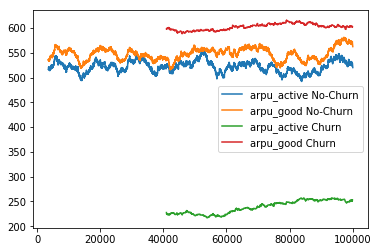

In [148]:
mov_avg_plot('arpu_good','arpu_active')

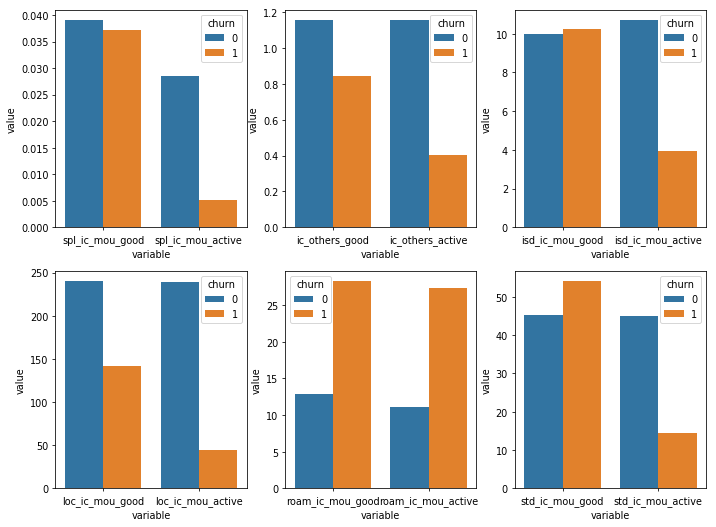

In [149]:
avg_bar_plot([('spl_ic_mou_good','spl_ic_mou_active'),('ic_others_good','ic_others_active'),
              ('isd_ic_mou_good','isd_ic_mou_active'),('loc_ic_mou_good','loc_ic_mou_active'),
              ('roam_ic_mou_good','roam_ic_mou_active'),('std_ic_mou_good','std_ic_mou_active')])

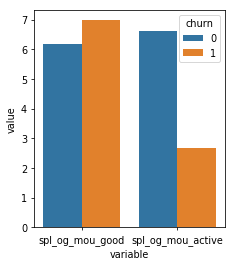

In [150]:
avg_bar_plot([('spl_og_mou_good','spl_og_mou_active')])

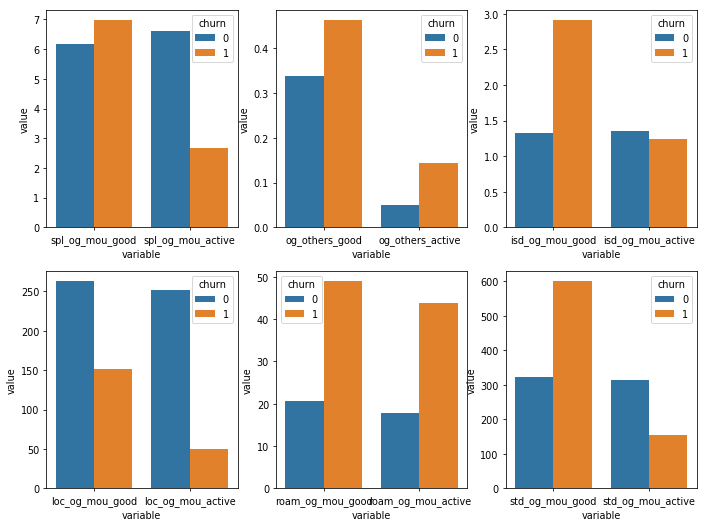

In [151]:
avg_bar_plot([('spl_og_mou_good','spl_og_mou_active'),
              ('og_others_good','og_others_active'),
              ('isd_og_mou_good','isd_og_mou_active'),
              ('loc_og_mou_good','loc_og_mou_active'),
              ('roam_og_mou_good','roam_og_mou_active'),
              ('std_og_mou_good','std_og_mou_active')])

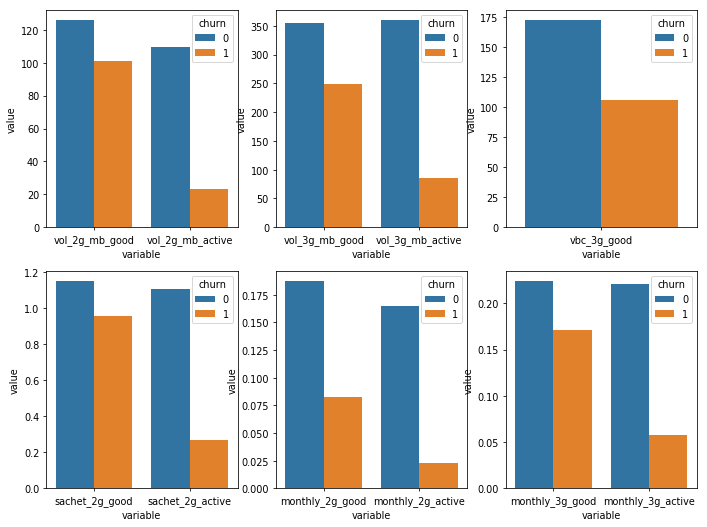

In [152]:
avg_bar_plot([('vol_2g_mb_good','vol_2g_mb_active'),
              ('vol_3g_mb_good','vol_3g_mb_active'),
              ('vbc_3g_good','vbc_3g_good'),
              ('sachet_2g_good', 'sachet_2g_active'),
              ('monthly_2g_good', 'monthly_2g_active'),
              ('monthly_3g_good', 'monthly_3g_active')])

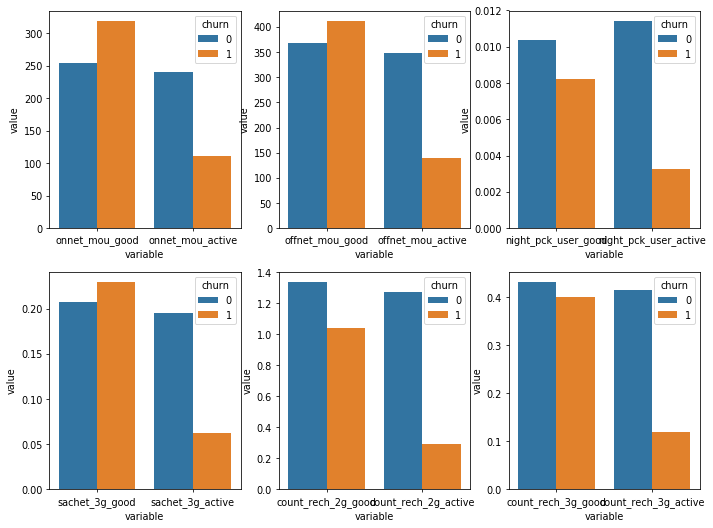

In [153]:
avg_bar_plot([('onnet_mou_good','onnet_mou_active'),
              ('offnet_mou_good','offnet_mou_active'),
              ('night_pck_user_good','night_pck_user_active'),
              ('sachet_3g_good','sachet_3g_active'),
              ('count_rech_2g_good','count_rech_2g_active'),
              ('count_rech_3g_good','count_rech_3g_active')])

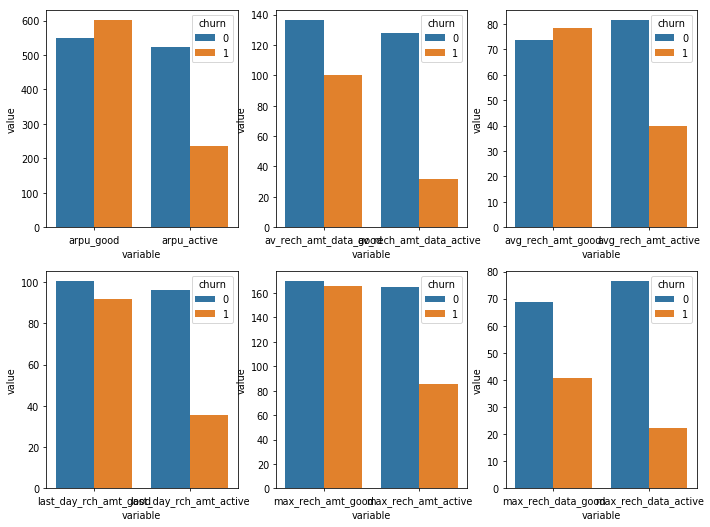

In [154]:
avg_bar_plot([('arpu_good','arpu_active'),
              ('av_rech_amt_data_good','av_rech_amt_data_active'),
              ('avg_rech_amt_good','avg_rech_amt_active'),
              ('last_day_rch_amt_good','last_day_rch_amt_active'),
              ('max_rech_amt_good','max_rech_amt_active'),
              ('max_rech_data_good','max_rech_data_active')])

#### Draw the stacked plots - Stacked plots identify the percentage of 'Churned' and 'Non-churned' Customers where there the KPIs have NaNs.

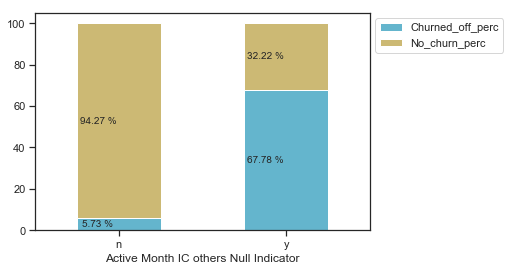

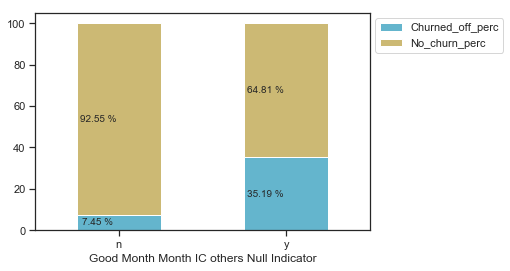

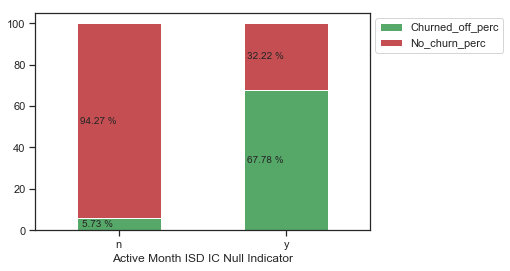

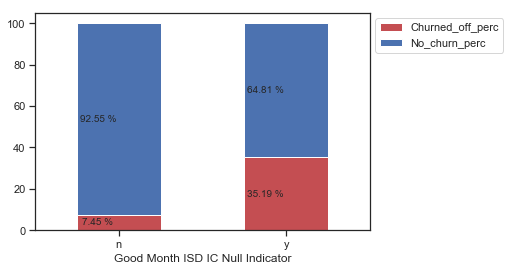

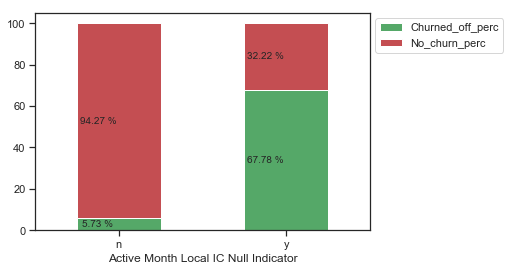

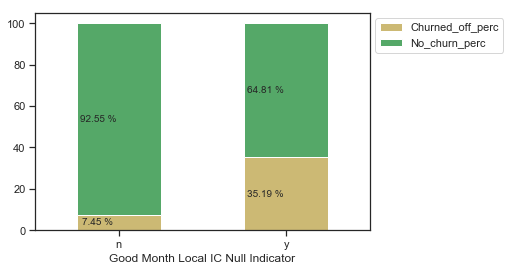

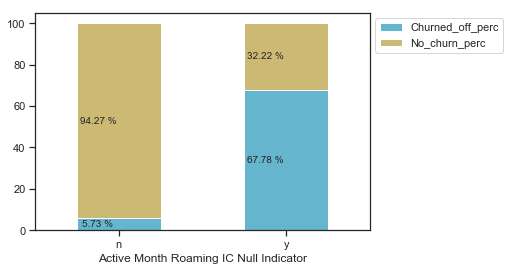

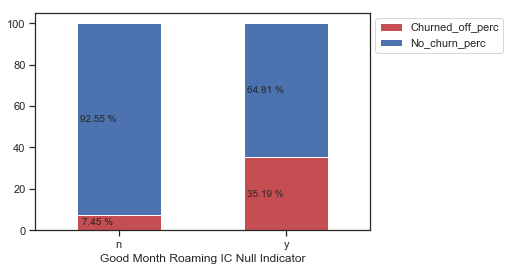

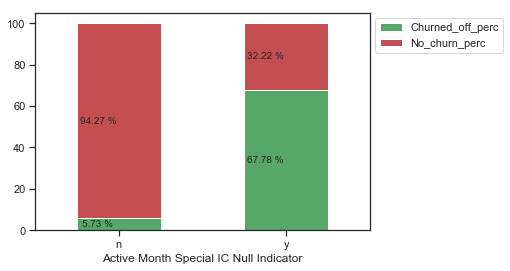

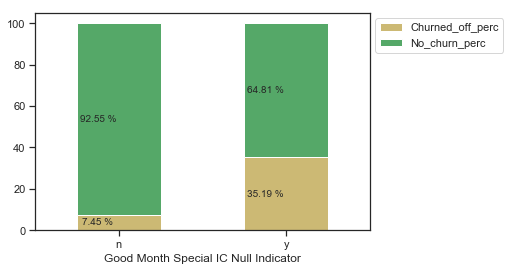

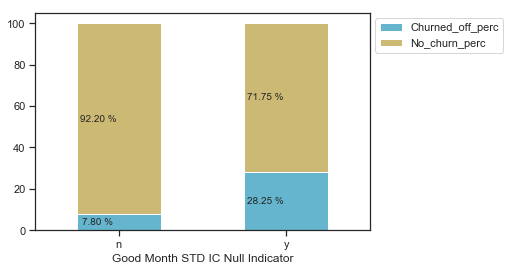

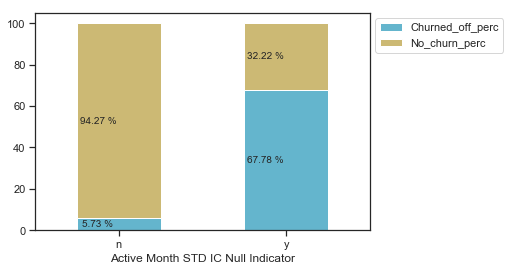

In [155]:
stacked_plot([('ic_others_null_active','Active Month IC others Null Indicator'),
              ('ic_others_null_good','Good Month Month IC others Null Indicator'),
              ('isd_ic_mou_null_active','Active Month ISD IC Null Indicator'),
              ('isd_ic_mou_null_good','Good Month ISD IC Null Indicator'),
              ('loc_ic_null_active','Active Month Local IC Null Indicator'),
              ('loc_ic_null_good','Good Month Local IC Null Indicator'),
              ('roam_ic_mou_null_active','Active Month Roaming IC Null Indicator'),
              ('roam_ic_mou_null_good','Good Month Roaming IC Null Indicator'),
              ('spl_ic_mou_null_active','Active Month Special IC Null Indicator'),
              ('spl_ic_mou_null_good','Good Month Special IC Null Indicator'),
              ('std_ic_mou__null_good','Good Month STD IC Null Indicator'),
              ('std_ic_mou_null_active','Active Month STD IC Null Indicator')])

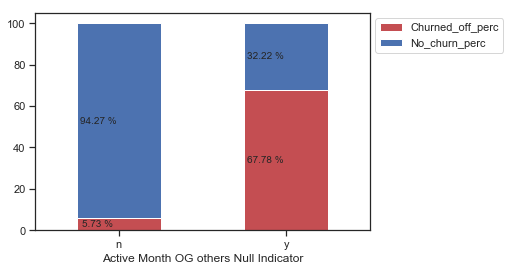

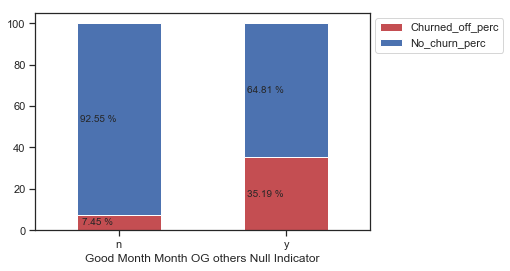

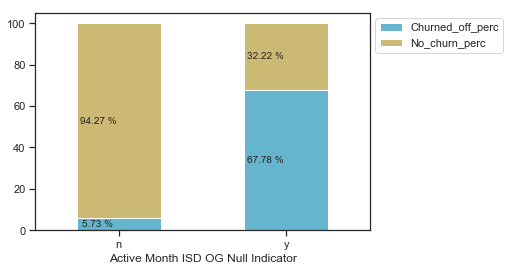

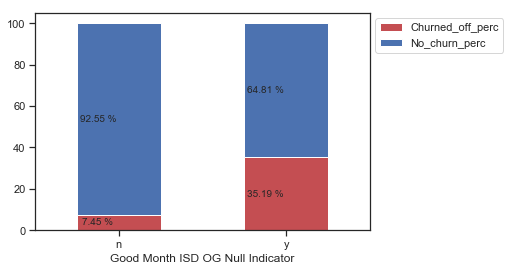

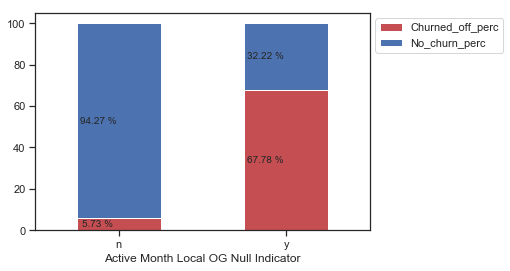

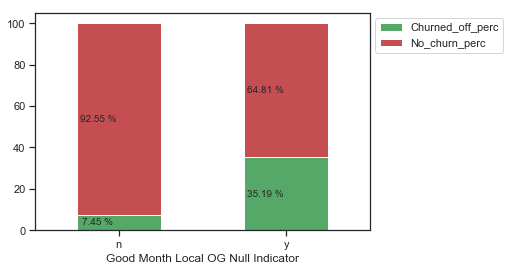

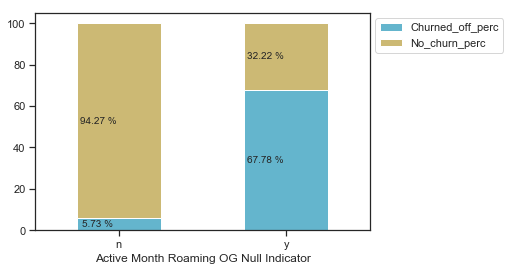

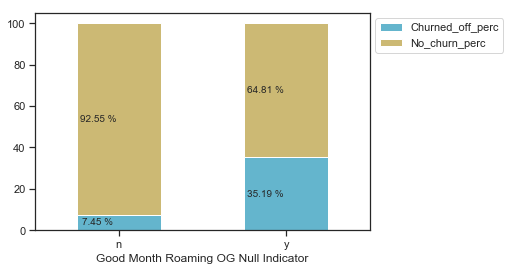

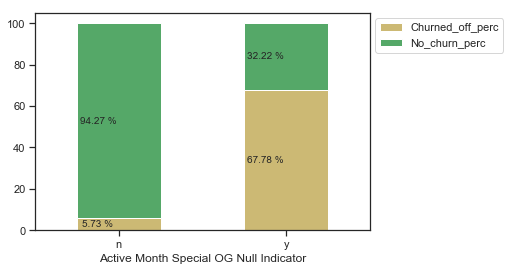

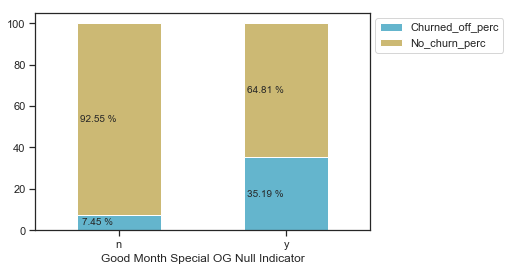

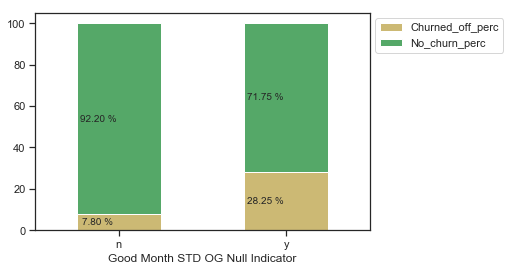

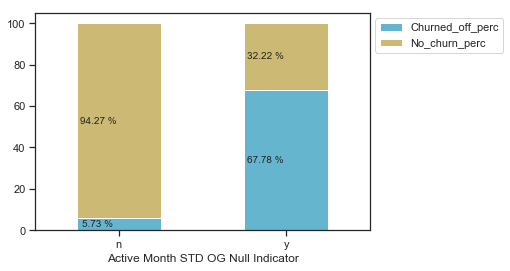

In [156]:
stacked_plot([('og_others_null_active','Active Month OG others Null Indicator'),
              ('og_others_null_good','Good Month Month OG others Null Indicator'),
              ('isd_og_mou_null_active','Active Month ISD OG Null Indicator'),
              ('isd_og_mou_null_good','Good Month ISD OG Null Indicator'),
              ('loc_og_null_active','Active Month Local OG Null Indicator'),
              ('loc_og_null_good','Good Month Local OG Null Indicator'),
              ('roam_og_mou_null_active','Active Month Roaming OG Null Indicator'),
              ('roam_og_mou_null_good','Good Month Roaming OG Null Indicator'),
              ('spl_og_mou_null_active','Active Month Special OG Null Indicator'),
              ('spl_og_mou_null_good','Good Month Special OG Null Indicator'),
              ('std_og_mou__null_good','Good Month STD OG Null Indicator'),
              ('std_og_mou_null_active','Active Month STD OG Null Indicator')])

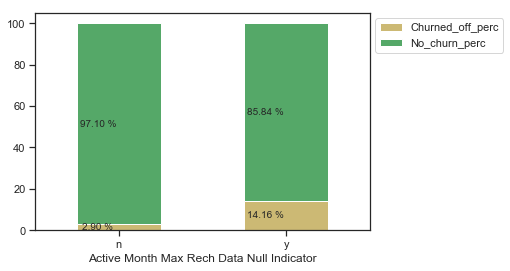

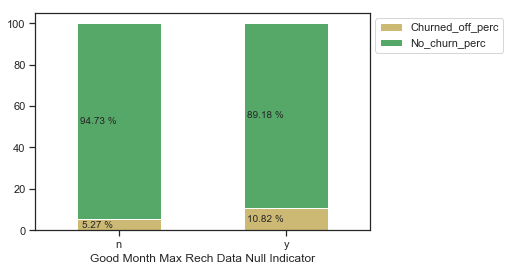

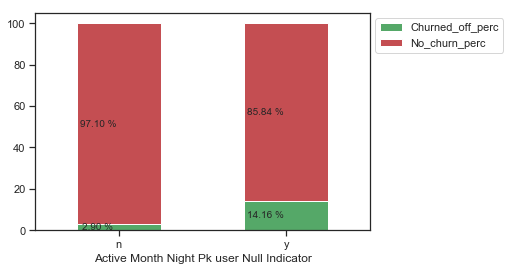

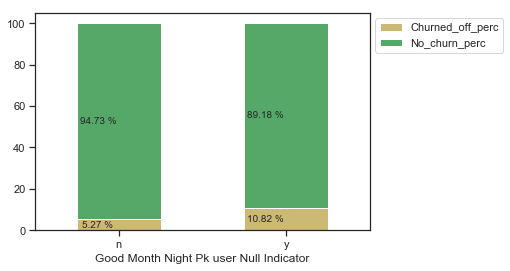

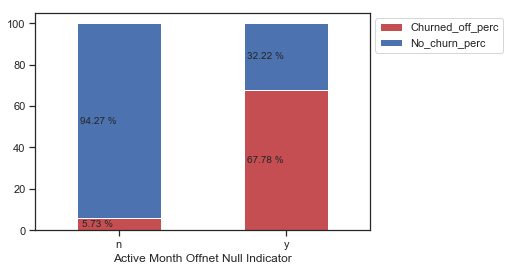

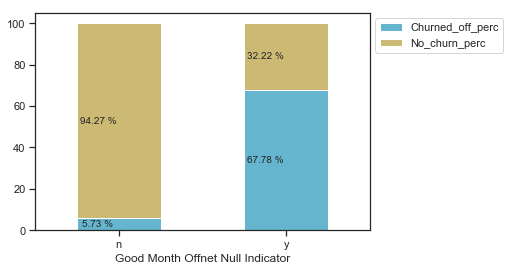

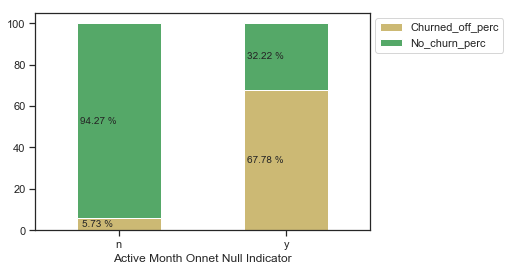

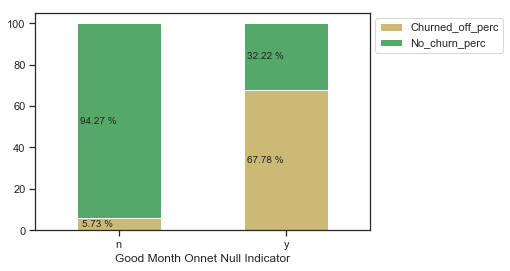

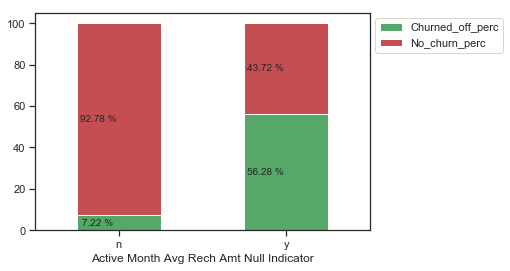

In [157]:
stacked_plot([('max_rech_data_null_active','Active Month Max Rech Data Null Indicator'),
              ('max_rech_data_null_good','Good Month Max Rech Data Null Indicator'),
              ('night_pck_user_null_active','Active Month Night Pk user Null Indicator'),
              ('night_pck_user_null_good','Good Month Night Pk user Null Indicator'),
              ('offnet_mou_null_active','Active Month Offnet Null Indicator'),
              ('offnet_mou_null_active','Good Month Offnet Null Indicator'),
              ('onnet_mou_null_active','Active Month Onnet Null Indicator'),
              ('onnet_mou_null_active','Good Month Onnet Null Indicator'),
              ('avg_rech_amt_null_active','Active Month Avg Rech Amt Null Indicator')])

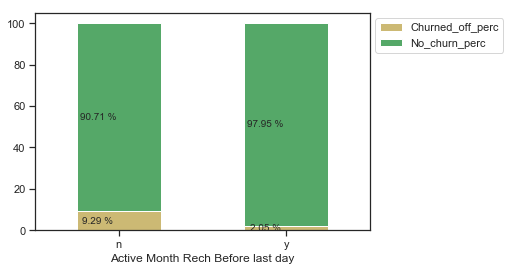

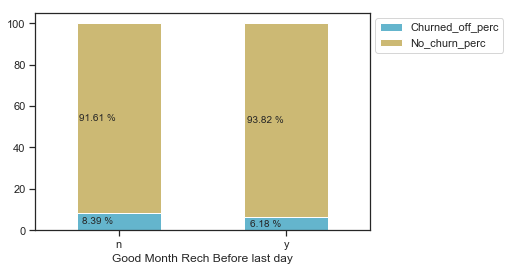

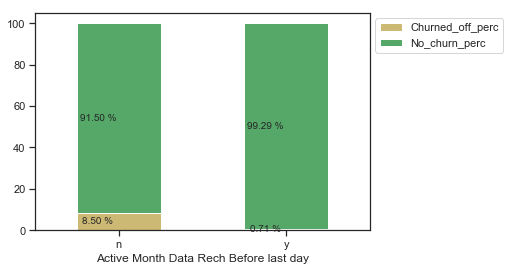

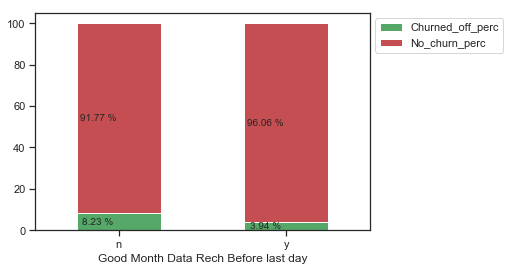

In [158]:
stacked_plot([('rech_before_lastday_active','Active Month Rech Before last day'),
              ('rech_before_lastday_good','Good Month Rech Before last day'),
              ('rechdata_before_lastday_active','Active Month Data Rech Before last day'),
              ('rechdata_before_lastday_good','Good Month Data Rech Before last day')])

#### Check the trend of IC, OG and Data usage across the months

In [159]:
hv_custdata_copy.fillna(0)
hv_custdata_copy.rename({'aug_vbc_3g':'vbc_3g_active','jul_vbc_3g':'vbc_3g_7','jun_vbc_3g':'vbc_3g_6'},axis='columns',inplace=True)

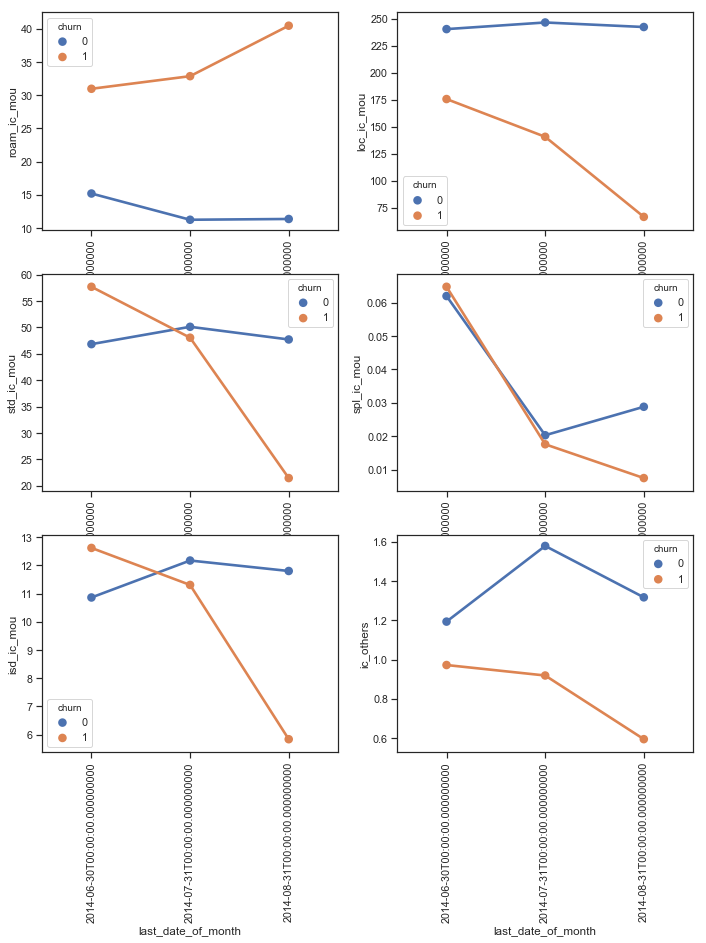

In [160]:
usage_across_time(['roam_ic_mou','loc_ic_mou','std_ic_mou','spl_ic_mou','isd_ic_mou','ic_others'])

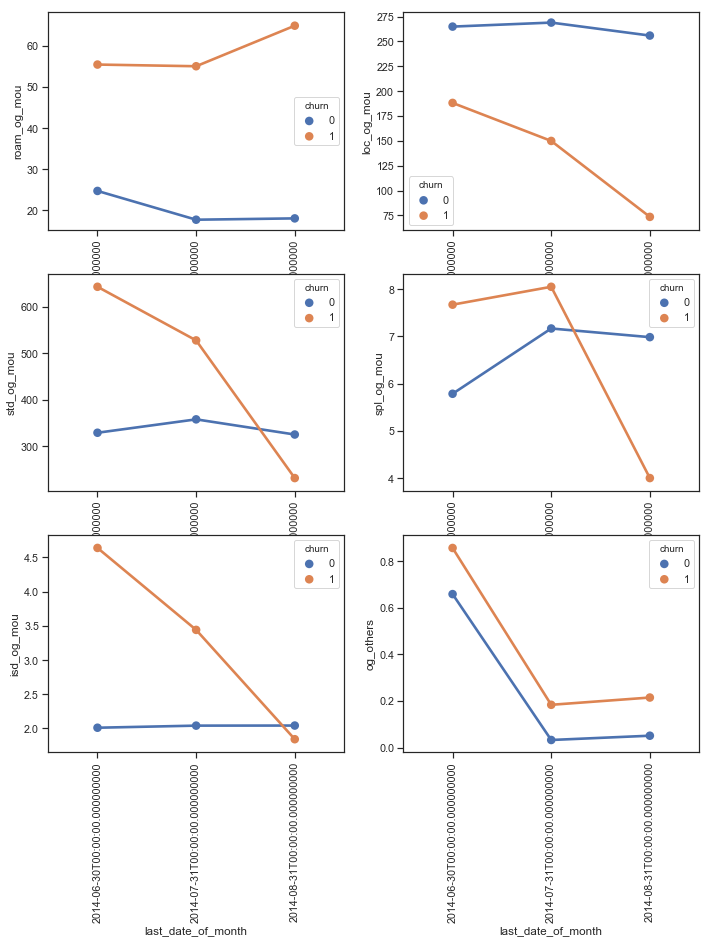

In [161]:
usage_across_time(['roam_og_mou','loc_og_mou','std_og_mou','spl_og_mou','isd_og_mou','og_others'])

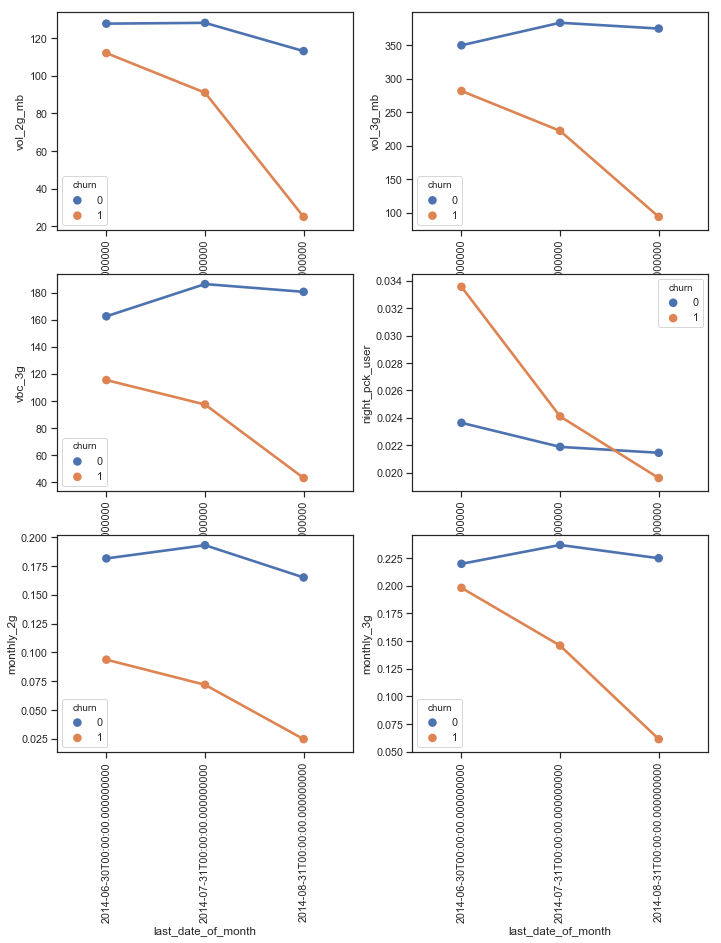

In [162]:
usage_across_time(['vol_2g_mb','vol_3g_mb','vbc_3g','night_pck_user','monthly_2g','monthly_3g'])

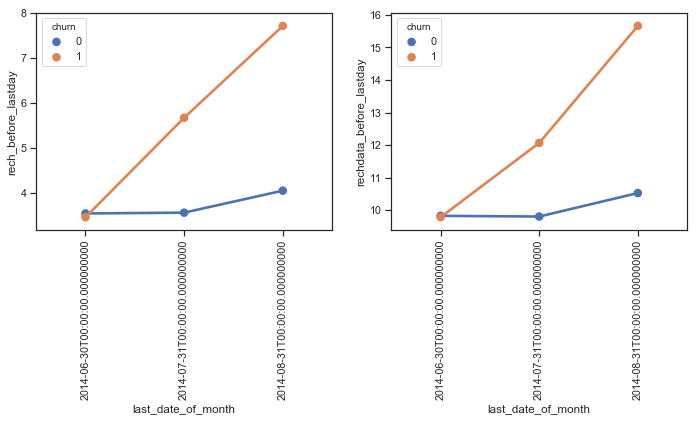

In [163]:
usage_across_time(['rech_before_lastday','rechdata_before_lastday'])

**Inferences from Data Visualisation:**
 - From 'Moving Average plot', it is evident that,Average Revenue Per User increases drastically from active months to good months, in case of users who have churned. The increase is marginal for non-churned users     - Users whose minutes of usage on incoming calls, outgoing calls reduce are more likely to churn than users whose mou patterns are unchanged. 
 - The evidence of change in the incoming calls, indicates the customer communication contact preference and is a staunch indicator of customer using alternate service provider.
 - Users who have reduced data volume, sachet, night-packs usage or reduced recharge count/amount are more likely to churn
 - Similarly users showing decreasing trend in onnet/offnet minutes of usage are more likely to churn out
 - Users for whome incoming and outgoing minutes of usage is null (not known) in the active month are shown to be chrning out more. However, same is not true for good months; i.e. users whose usage for good month is not known may not churn out
 - Users whose onnet and offnet usage is null (not known) for either good/active months are shown to be churning more
 - From the above two points, it is recommended that the data sourcing methods for these KPIs shoudl be reviewed. 
 - An interesting pattern is that special outgoing calls increase for all users in the second good month, however reduces significantly in the third month in case of churned users. Assuming special outgoing calls to be to the customer-care, this might be early signs of customer not being happy.
 - Another interesting trend shown in the data is that for chruned out users roaming incoming and outgoing usage increases while other incoming outgoing usage reduces. Opposite is also true, i.e. for non-churn users roaming usage reduces while other incoming and outgoing usage increases. 
 - The above behaviour can be indicator of the fact that users who have migrated to other places are more likely to switch network and thus churn. 
 - The large gap between the recharge date and the last month date is staunch indicator, as the churn customer will not look at recharging close to the month end.  
    

### Stage 4 - Apply Dimensionality Reduction (PCA) and Balance the class as appropriate

In [164]:
print(hv_custdata.shape)
hv_custdata.head()

(29753, 105)


,mobile_number,arpu_active,onnet_mou_active,offnet_mou_active,roam_ic_mou_active,roam_og_mou_active,loc_og_mou_active,std_og_mou_active,isd_og_mou_active,spl_og_mou_active,og_others_active,loc_ic_mou_active,std_ic_mou_active,spl_ic_mou_active,isd_ic_mou_active,ic_others_active,max_rech_amt_active,last_day_rch_amt_active,max_rech_data_active,count_rech_2g_active,count_rech_3g_active,av_rech_amt_data_active,vol_2g_mb_active,vol_3g_mb_active,night_pck_user_active,monthly_2g_active,sachet_2g_active,monthly_3g_active,sachet_3g_active,aon,avg_good_month_rech_amt,churn,rech_before_lastday_active,rechdata_before_lastday_active,arpu_good,vbc_3g_good,vbc_3g_active,count_rech_2g_good,count_rech_3g_good,fb_not_known_active,fb_user_good,fb_not_known_good,vol_2g_mb_good,vol_3g_mb_good,monthly_2g_good,monthly_3g_good,loc_ic_mou_good,loc_ic_null_good,loc_ic_null_active,loc_og_mou_good,loc_og_null_good,loc_og_null_active,max_rech_amt_good,max_rech_data_good,max_rech_data_null_good,max_rech_data_null_active,night_pck_user_good,night_pck_user_null_good,night_pck_user_null_active,onnet_mou_good,offnet_mou_good,onnet_mou_null_good,onnet_mou_null_active,offnet_mou_null_good,offnet_mou_null_active,sachet_2g_good,sachet_3g_good,std_ic_mou_good,std_ic_mou__null_good,std_ic_mou_null_active,roam_ic_mou_good,roam_ic_mou_null_good,roam_ic_mou_null_active,spl_ic_mou_good,spl_ic_mou_null_good,spl_ic_mou_null_active,ic_others_good,ic_others_null_good,ic_others_null_active,isd_ic_mou_good,isd_ic_mou_null_good,isd_ic_mou_null_active,std_og_mou_good,std_og_mou__null_good,std_og_mou_null_active,roam_og_mou_good,roam_og_mou_null_good,roam_og_mou_null_active,spl_og_mou_good,spl_og_mou_null_good,spl_og_mou_null_active,og_others_good,og_others_null_good,og_others_null_active,isd_og_mou_good,isd_og_mou_null_good,isd_og_mou_null_active,av_rech_amt_data_good,avg_rech_amt_good,avg_rech_amt_active,avg_rech_amt_null_active,last_day_rch_amt_good,churn_text,rech_before_lastday_good,rechdata_before_lastday_good
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.44,0.00,0.00,0.00,0.00,252,252,252.00,0.00,1.00,252.00,5.75,109.61,0.00,0,0,1,0,968,559.00,1,0,0,206.10,50.60,30.40,0.00,1.00,0,1,0,15.72,117.16,0.00,1.00,0.00,1,0,0.00,1,0,252.00,252.00,0,0,0.00,0,0,0.00,0.00,1,0,1,0,0.00,0.00,0.00,1,0,0.00,1,0,0.00,1,0,0.00,1,0,0.00,1,0,0.00,1,0,0.00,1,0,0.00,1,0,0.00,1,0,0.00,1,0,252.00,87.71,126.00,0,252.00,churn,0,0
7,7000701601,"3,171.48",52.29,325.91,31.64,38.06,255.79,77.83,10.01,6.50,0.00,188.04,193.93,0.00,31.59,15.14,1580,779,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,"1,185.00",1,0,0,"1,209.51",19.06,57.74,0.00,0.00,1,0,1,0.00,0.00,0.00,0.00,391.56,0,0,478.02,0,0,"1,185.00",0.00,1,1,0.00,1,1,56.26,510.29,0,0,0,0,0.00,0.00,180.52,0,0,24.86,0,0,0.10,0,0,15.46,0,0,8.29,0,0,60.85,0,0,18.16,0,0,2.25,0,0,0.00,0,0,0.09,0,0,0.00,237.00,519.71,0,0.00,churn,0,0
8,7001524846,137.36,35.08,136.48,0.00,0.00,70.18,98.27,0.00,10.23,0.00,15.79,0.75,0.00,0.00,0.00,30,10,23.00,3.00,0.00,69.00,0.03,11.94,0.00,0,3,0,0,315,696.00,0,1,0,435.47,516.40,21.03,1.00,0.00,0,1,0,178.00,375.48,0.50,0.00,52.63,0,0,333.13,0,0,122.00,0.00,1,0,0.00,1,0,382.36,87.64,0,0,0,0,0.50,0.00,22.43,0,0,0.00,0,0,0.00,0,0,0.00,0,0,0.00,0,0,130.25,0,0,0.00,0,0,0.00,0,0,0.00,0,0,0.00,0,0,88.50,25.95,8.57,0,25.00,no-churn,0,0
21,7002124215,637.76,85.14,983.39,0.00,0.00,129.73,938.78,0.00,0.00,0.00,159.11,101.92,0.00,0.00,0.00,50,50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,720,640.00,0,0,0,556.10,0.00,0.00,0.00,0.00,1,0,1,0.00,0.00,0.00,0.00,106.50,0,0,95.56,0,0,50.00,0.00,1,1,0.00,1,1,117.26,827.30,0,0,0,0,0.00,0.00,81.75,0,0,0.00,0,0,0.00,0,0,0.00,0,0,0.00,0,0,763.29,0,0,0.00,0,0,0.00,0,0,0.00,0,0,0.00,0,0,0.00,26.67,26.59,0,25.00,no-churn,0,0
23,7000887461,366.97,33.58,205.89,0.00,0.00,199.85,39.61,0.00,17.71,0.00,224.21,57.29,0.00,3.74,13.06,179,0,179.00,0.00,2.00,270.00,0.01,"1,009.92",0.00,0,0,1,1,604,583.00,0,0,0,134.12,25.93,40.45,0.00,1.00,0,1,0,0.24,299.55,0.00,1.00,145.52,0,0,132.79,0,0,89.

In [165]:
#Drop columns that have same values
hv_custdata_unique=hv_custdata.nunique().sort_values()
unique_cols=hv_custdata_unique[hv_custdata_unique==1].index
hv_custdata.drop(columns=unique_cols,axis=1,inplace=True)

In [166]:
print(hv_custdata.shape)

(29753, 105)


In [167]:
# Standardizing the values
hv_custdata_features=hv_custdata.drop(['mobile_number','churn_text','rech_before_lastday_active','rechdata_before_lastday_active','rech_before_lastday_good','rechdata_before_lastday_good'],axis=1)
#hv_custdata_features=hv_custdata.drop(['mobile_number','churn_text'],axis=1)
cols=list(hv_custdata_features.columns)
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(hv_custdata_features)
hv_custdata_std=pd.DataFrame(scaled_df, columns=cols)

In [168]:
# Put feature variable to x and response variable to y
x = hv_custdata_std.drop(['churn'],axis=1)
y = hv_custdata_std['churn']

# Split the set
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.7,test_size=0.3,random_state=100)
print(y_train.mean())
print(y_train.value_counts())


0.08311326643299563
0.00    19096
1.00     1731
Name: churn, dtype: int64


In [169]:
# Create a frame and empty lists to store the predictor and actual values that help easy model visualisation
score_frame=pd.DataFrame()
algorithm_name=[]
recall_scores=[]
f1_scores=[]
accuracy_scores=[]


# Define function to predict the test data set usinf given algorithm
def run_algorithm(algo,x_train_set,y_train_set,x_test_set,y_test_set,algo_name,roc_req):
    # algo - model object
    # x_train_set - Independent variables from test set
    # y_train_set - Predictor variable from training set 
    # x_test_set - Independent variables from test set 
    # y_test_set - Predictor variable from test set
    # algo_name - Algorithm Name 
    # roc_req - Calculations of roc, acu and coefficeints
    
    algo_model = algo.fit(x_train_set,y_train_set)

    # predict values and probabilities
    y_pred=algo_model.predict(x_test_set)
    y_prob=algo_model.predict_proba(x_test_set)[:,1]
    y_pred_train=algo_model.predict(x_train_set)
    
    # Print Values
    print (algo_name +' : ')
    print('-------------------------')
    print("Classification report : ","\n", classification_report(y_test,y_pred))
    print("Accuracy   Score : ",accuracy_score(y_test,y_pred))
    print("Recall Score on train Set: ",metrics.recall_score(y_train_set,y_pred_train))
    print("Recall Score on test Set: ",metrics.recall_score(y_test,y_pred))
    
    # Set up frames for model scores for later use
    algorithm_name.append(algo_name)
    recall_scores.append(metrics.recall_score(y_test,y_pred))
    f1_scores.append(metrics.f1_score(y_test,y_pred))
    accuracy_scores.append(accuracy_score(y_test,y_pred))
    
    # Plot the ROC curve 
    if roc_req == 'y':
        model_roc_auc = roc_auc_score(y_test,y_pred) 
        print ("Area under curve : ",model_roc_auc,"\n")
        print("Confusion Matrix: ","\n",metrics.confusion_matrix(y_test,y_prob.round()))
        
        fpr,tpr,threshold = roc_curve(y_test,y_prob)
     
        plt.figure(figsize=(5, 5))
        plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % model_roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()
    return y_test,y_prob 

# PCA

In [170]:
x_train.shape

(20827, 98)

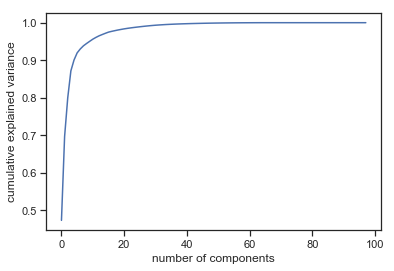

In [171]:
# Apply PCA on the Sampled data and Run logistic Regression
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

**Inference:**
 - In accordance to the above cumulative explained variance curve, to explain 97%+ variance, 25 components will suffice

In [172]:
pca_final = IncrementalPCA(n_components=25)
x_train_pca = pca_final.fit_transform(x_train)
y_train_pca = y_train
x_test_pca = pca_final.transform(x_test)

print(x_test_pca.shape)
print(x_train_pca.shape)

(8926, 25)
(20827, 25)


The following strategy will be followed for class balancing - 
 - Run the Logistic Regression to understand the current data status and accurancy model
 - Apply different sampling techniques - SMOTE, ADASYN and Random under sampling. For each sampling, build the model and check metrics
 - Select the sampling technique that gives best metrics

In [173]:
# Run the Logistic Regression to understand the current data status
logreg = LogisticRegression(random_state=42)
dummy_var,dummy_var=run_algorithm(logreg,x_train_pca,y_train_pca,x_test_pca,y_test,'Logistic_Regression_Actual_Data','n')

Logistic_Regression_Actual_Data : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      8225
         1.0       0.80      0.34      0.48       701

   micro avg       0.94      0.94      0.94      8926
   macro avg       0.87      0.67      0.72      8926
weighted avg       0.93      0.94      0.93      8926

Accuracy   Score :  0.9414071252520726
Recall Score on train Set:  0.31311380704794917
Recall Score on test Set:  0.340941512125535


In [174]:
# Using the SMOTE techinue (Over Sampling) and run Logistic Regression 
smt = SMOTE(random_state = 42)
x_train_smt, y_train_smt = smt.fit_sample(x_train_pca, y_train_pca)
print('y_train SMOTE Mean: ',y_train_smt.mean(),"\n")

logreg = LogisticRegression(random_state = 42)
dummy_var,dummy_var=run_algorithm(logreg,x_train_smt,y_train_smt,x_test_pca,y_test,'Logistic_Regression_SMOTE','n')

adbc = AdaBoostClassifier(n_estimators=10,learning_rate=1)
dummy_var,dummy_var=run_algorithm(adbc,x_train_smt,y_train_smt,x_test_pca,y_test,'Adaboost_Classifier_SMOTE','n')


y_train SMOTE Mean:  0.5 

Logistic_Regression_SMOTE : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.98      0.82      0.89      8225
         1.0       0.28      0.81      0.41       701

   micro avg       0.82      0.82      0.82      8926
   macro avg       0.63      0.81      0.65      8926
weighted avg       0.93      0.82      0.86      8926

Accuracy   Score :  0.819852117409814
Recall Score on train Set:  0.8000104733975701
Recall Score on test Set:  0.8074179743223966
Adaboost_Classifier_SMOTE : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.98      0.83      0.89      8225
         1.0       0.27      0.76      0.40       701

   micro avg       0.82      0.82      0.82      8926
   macro avg       0.62      0.79      0.65      8926
weighted avg       0.92      0.82      0.86      8926

Accuracy   Score :  0.82

In [175]:
# Apply Adaptive Over Sampling technique
asmt = ADASYN(random_state = 42)
x_train_asmt, y_train_asmt = asmt.fit_sample(x_train_pca, y_train_pca)
print('y_train Adaptive Over Sampling Mean: ',y_train_asmt.mean(),"\n")

logreg = LogisticRegression(random_state = 42)
dummy_var,dummy_var=run_algorithm(logreg,x_train_asmt,y_train_asmt,x_test_pca,y_test,'Logistic Regression ADASYN','n')

adbc = AdaBoostClassifier(n_estimators=10,learning_rate=1)
dummy_var,dummy_var=run_algorithm(adbc,x_train_asmt,y_train_asmt,x_test_pca,y_test,'Adaboost Classifier ADASYN','n')


y_train Adaptive Over Sampling Mean:  0.5027471812098013 

Logistic Regression ADASYN : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.98      0.74      0.85      8225
         1.0       0.22      0.86      0.35       701

   micro avg       0.75      0.75      0.75      8926
   macro avg       0.60      0.80      0.60      8926
weighted avg       0.92      0.75      0.81      8926

Accuracy   Score :  0.7516244678467399
Recall Score on train Set:  0.7957217589475319
Recall Score on test Set:  0.8573466476462197
Adaboost Classifier ADASYN : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.98      0.75      0.85      8225
         1.0       0.22      0.83      0.35       701

   micro avg       0.76      0.76      0.76      8926
   macro avg       0.60      0.79      0.60      8926
weighted avg       0.92      0.76      0.81 

In [176]:
# Apply Random Under Sampling Techique 
rusm=RandomUnderSampler(random_state = 42)
x_train_rusm, y_train_rusm = rusm.fit_sample(x_train_pca, y_train_pca)
print('y_train Random Under Sampling Mean: ',y_train_rusm.mean(),"\n")

logreg = LogisticRegression()
dummy_var,dummy_var=run_algorithm(logreg,x_train_rusm,y_train_rusm,x_test_pca,y_test,'Logistic_Regression RUS Samp','n')

print("\n")

adbc = AdaBoostClassifier(n_estimators=10,learning_rate=1)
dummy_var,dummy_var=run_algorithm(adbc,x_train_rusm,y_train_rusm,x_test_pca,y_test,'Adaboost_Classifier RUS Samp','n')



y_train Random Under Sampling Mean:  0.5 

Logistic_Regression RUS Samp : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.98      0.81      0.88      8225
         1.0       0.26      0.79      0.39       701

   micro avg       0.81      0.81      0.81      8926
   macro avg       0.62      0.80      0.64      8926
weighted avg       0.92      0.81      0.85      8926

Accuracy   Score :  0.8053999551870938
Recall Score on train Set:  0.7729636048526863
Recall Score on test Set:  0.7945791726105563


Adaboost_Classifier RUS Samp : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.98      0.80      0.88      8225
         1.0       0.25      0.77      0.38       701

   micro avg       0.80      0.80      0.80      8926
   macro avg       0.61      0.79      0.63      8926
weighted avg       0.92      0.80      0.84      8926


**Inference :**
- As per the metrics above, the recall and the overall performance of the model is better when the class is balances using ADYSN Sampling technique. 
So, select the 'ADYSN' sampling technique for this analysis.

### Stage 5 - Train ML models and derive the associated metrics

Simple Logistic Regression : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.98      0.74      0.85      8225
         1.0       0.22      0.86      0.35       701

   micro avg       0.75      0.75      0.75      8926
   macro avg       0.60      0.80      0.60      8926
weighted avg       0.92      0.75      0.81      8926

Accuracy   Score :  0.7516244678467399
Recall Score on train Set:  0.7957217589475319
Recall Score on test Set:  0.8573466476462197
Area under curve :  0.7999803147045689 

Confusion Matrix:  
 [[6108 2117]
 [ 100  601]]


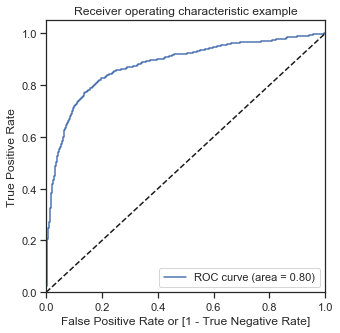

In [177]:
# Apply Logistic Classifier
logreg = LogisticRegression(random_state=42)
y_test_logrec,y_prob_logrec=run_algorithm(logreg,x_train_asmt,y_train_asmt,x_test_pca,y_test,'Simple Logistic Regression','y')
score_frame['Test_Logrec']=y_test_logrec
score_frame['Prob_Logrec']=y_prob_logrec

In [178]:
#Grid Search
logreg = LogisticRegression(random_state=42)
param = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5,10,20]}
clf = GridSearchCV(logreg,param,scoring='recall',refit=True,cv=10)
clf.fit(x_train_asmt,y_train_asmt)
print('Best recall: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))


Best recall: 0.7909, with best C: {'C': 4}


Logistic_Reg_P : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.98      0.74      0.85      8225
         1.0       0.22      0.86      0.35       701

   micro avg       0.75      0.75      0.75      8926
   macro avg       0.60      0.80      0.60      8926
weighted avg       0.92      0.75      0.81      8926

Accuracy   Score :  0.7518485323773246
Recall Score on train Set:  0.7964468845496452
Recall Score on test Set:  0.8559201141226819
Area under curve :  0.7994494187634685 

Confusion Matrix:  
 [[6111 2114]
 [ 101  600]]


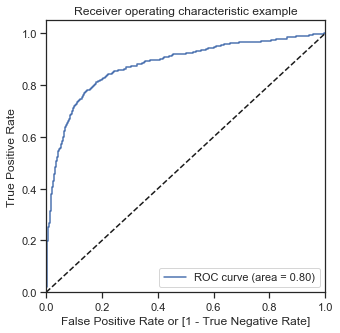

In [179]:
# Logistic Regression with best gamma constant
logreg_cv = LogisticRegression(random_state=42, C=clf.best_params_['C'])
y_test_logrec_p,y_prob_logrec_p=run_algorithm(logreg_cv,x_train_asmt,y_train_asmt,x_test_pca,y_test,'Logistic_Reg_P','y')
score_frame['Test_Logrec_p']=y_test_logrec_p
score_frame['Prob_Logrec_p']=y_prob_logrec_p

Logistic_Regression_BW : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.98      0.81      0.89      8225
         1.0       0.27      0.81      0.41       701

   micro avg       0.81      0.81      0.81      8926
   macro avg       0.63      0.81      0.65      8926
weighted avg       0.92      0.81      0.85      8926

Accuracy   Score :  0.8144745686757786
Recall Score on train Set:  0.7764298093587522
Recall Score on test Set:  0.8102710413694721
Area under curve :  0.8125519340585963 

Confusion Matrix:  
 [[6702 1523]
 [ 133  568]]


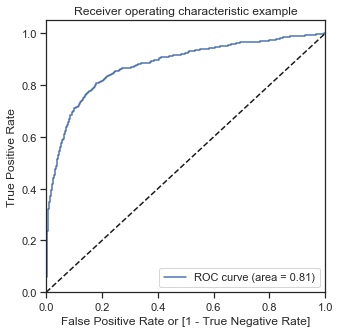

In [180]:
#Logistic Regression with balanced weights
logreg_bal = LogisticRegression(random_state=42, class_weight='balanced')
y_test_logrec_bw,y_prob_logrec_bw=run_algorithm(logreg_bal,x_train_pca,y_train_pca,x_test_pca,y_test,'Logistic_Regression_BW','y')
score_frame['Test_Logrec_BW']=y_test_logrec_bw
score_frame['Prob_Logrec_BW']=y_prob_logrec_bw

Logistic_Regression_BW_P : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.98      0.81      0.89      8225
         1.0       0.27      0.81      0.41       701

   micro avg       0.81      0.81      0.81      8926
   macro avg       0.63      0.81      0.65      8926
weighted avg       0.93      0.81      0.85      8926

Accuracy   Score :  0.8149226977369483
Recall Score on train Set:  0.779896013864818
Recall Score on test Set:  0.8145506419400856
Area under curve :  0.8147525246174592 

Confusion Matrix:  
 [[6703 1522]
 [ 130  571]]


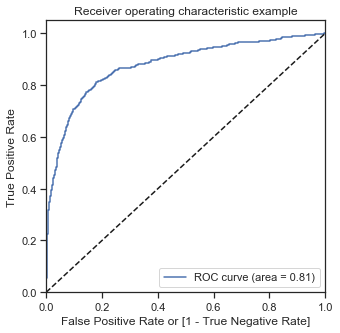

In [181]:
#Logistic Regression with balanced weights and Penalty
logreg_bal_p = LogisticRegression(random_state=42, class_weight='balanced',C=clf.best_params_['C'])
y_test_logrec_bwp,y_prob_logrec_bwp=run_algorithm(logreg_bal_p,x_train_pca,y_train_pca,x_test_pca,y_test,'Logistic_Regression_BW_P','y')
score_frame['Test_Logrec_BW_P']=y_test_logrec_bwp
score_frame['Prob_Logrec_BW_P']=y_prob_logrec_bwp

Random_Forest_Classifier : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      8225
         1.0       0.41      0.58      0.48       701

   micro avg       0.90      0.90      0.90      8926
   macro avg       0.69      0.75      0.71      8926
weighted avg       0.92      0.90      0.91      8926

Accuracy   Score :  0.9007394129509299
Recall Score on train Set:  0.998653338167504
Recall Score on test Set:  0.579172610556348
Area under curve :  0.7536592536064415 

Confusion Matrix:  
 [[7634  591]
 [ 295  406]]


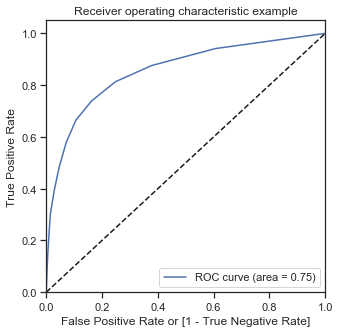

In [182]:
# Instantiate the basic random forest model
rf = RandomForestClassifier(random_state=42)
dummy_var,dummy_var=run_algorithm(rf,x_train_asmt,y_train_asmt,x_test_pca,y_test,'Random_Forest_Classifier','y')

In [183]:
[estimator.tree_.max_depth for estimator in rf.estimators_]

[37, 43, 33, 37, 40, 35, 40, 36, 33, 48]

In [184]:
# GridSearchCV to find optimal maximum depth and min_samples_leaf
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(10, 50, 4),
              'min_samples_leaf': [3,4,5,6] }

# instantiate the model
rf = RandomForestClassifier(random_state=42)

rf = GridSearchCV(rf, param_grid=parameters,
                  cv=n_folds, 
                 scoring="recall")

rf.fit(x_train_asmt, y_train_asmt)

print('\n'+'Enter the best parameters: ',rf.best_params_)


Enter the best parameters:  {'max_depth': 14, 'min_samples_leaf': 3}


Random_Forest_Classifier_T : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.97      0.88      0.93      8225
         1.0       0.34      0.72      0.46       701

   micro avg       0.87      0.87      0.87      8926
   macro avg       0.66      0.80      0.69      8926
weighted avg       0.92      0.87      0.89      8926

Accuracy   Score :  0.8686981850773022
Recall Score on train Set:  0.990314393743202
Recall Score on test Set:  0.7218259629101283
Area under curve :  0.8015208841906266 

Confusion Matrix:  
 [[7248  977]
 [ 195  506]]


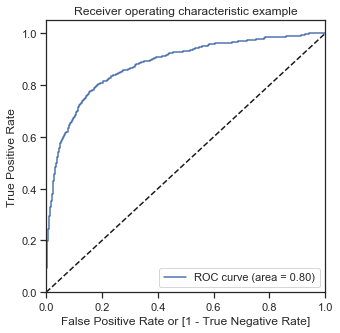

In [185]:
# model with the best hyperparameters
rf_tuned = RandomForestClassifier(bootstrap=True,
                             max_depth=rf.best_params_['max_depth'],
                             min_samples_leaf=rf.best_params_['min_samples_leaf'],
                             n_estimators=100,
                             random_state=42)

y_test_rfc,y_prob_rfc=run_algorithm(rf_tuned,x_train_asmt,y_train_asmt,x_test_pca,y_test,'Random_Forest_Classifier_T','y')
score_frame['Test_RFC']=y_test_rfc
score_frame['Prob_RFC']=y_prob_rfc

Adaboost_Classifier : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      8225
         1.0       0.23      0.83      0.36       701

   micro avg       0.77      0.77      0.77      8926
   macro avg       0.61      0.80      0.61      8926
weighted avg       0.92      0.77      0.82      8926

Accuracy   Score :  0.7722384046605423
Recall Score on train Set:  0.785621795203812
Recall Score on test Set:  0.8288159771754636
Area under curve :  0.7981161952746619 

Confusion Matrix:  
 [[6312 1913]
 [ 120  581]]


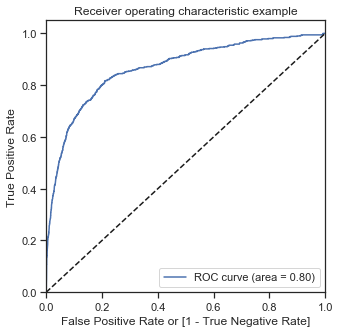

In [186]:
# Apply Adaboost Classifier
adbc = AdaBoostClassifier(n_estimators=50,learning_rate=1,random_state=42)
y_test_abc,y_prob_abc=run_algorithm(adbc,x_train_asmt,y_train_asmt,x_test_pca,y_test,'Adaboost_Classifier','y')
score_frame['Test_ABC']=y_test_abc
score_frame['Prob_ABC']=y_prob_abc

In [187]:
# Apply XG Boost Regressor
xgb=XGBClassifier(random_state=42)
xgb_model = xgb.fit(x_train_asmt,y_train_asmt)

# predict values and probabilities
y_pred=xgb_model.predict(x_test_pca)

y_train_pred = xgb_model.predict(x_train_asmt)
print("Performance on train set: ", metrics.recall_score(y_train_asmt, y_train_pred.round()))

y_test_pred = xgb_model.predict(x_test_pca)
print("Performance on test set: ", metrics.recall_score(y_test, y_test_pred.round()),"\n")

# Print Values
print ('XGBooster algorithm' +' : ')
print('-------------------------')
print("Classification report : ","\n", classification_report(y_test,y_pred.round()))
print("Accuracy   Score : ",accuracy_score(y_test,y_pred.round()))
print("Recall Score on Test Set: ",metrics.recall_score(y_test,y_pred.round()))

score_frame['Test_XGBC']=y_test
score_frame['Prob_XGBC']=y_pred.round()

Performance on train set:  0.8224478168539908
Performance on test set:  0.8316690442225392 

XGBooster algorithm : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.98      0.79      0.88      8225
         1.0       0.25      0.83      0.39       701

   micro avg       0.79      0.79      0.79      8926
   macro avg       0.62      0.81      0.63      8926
weighted avg       0.92      0.79      0.84      8926

Accuracy   Score :  0.7934125028008067
Recall Score on Test Set:  0.8316690442225392


### Stage 6 - Derive the prominent features and predictions

In [188]:
x_train.shape

(20827, 98)

In [189]:
# Define function for a logistic classifier and apply RFE to derive the prominent features. Check multi colienarity.

def logrec_rfe(a):
    # Feature variable = x and response variable = y
    xcols=a.columns
    
    # Use ADASYN for Over Sampling
    asmt = ADASYN(random_state = 42)
    x_train_asmt, y_train_asmt = asmt.fit_sample(a, y_train)
    print('y_train Adaptive Over Sampling Mean: ',y_train_asmt.mean(),"\n")
    
    # Set the train and test data
    x_train_samp = pd.DataFrame(data=x_train_asmt,columns=xcols)
    y_train_samp= pd.DataFrame(data=y_train_asmt,columns=['churn'])

    # Run RFE on logistic Regression
    logreg_rfe = LogisticRegression(random_state=42)
    rfe = RFE(logreg_rfe,25)             # running RFE with 25 variables as output
    rfe = rfe.fit(x_train_samp, y_train_samp)

    # Select the columns that are supported by RFE
    col = x_train_samp.columns[rfe.support_]

    x_train_sm = sm.add_constant(x_train_samp[col])
    logm2 = sm.GLM(y_train_samp,x_train_sm, family = sm.families.Binomial())
    res = logm2.fit()
    
    # Check Multi colinearity using VIF
    vif = pd.DataFrame()
    vif['features'] = x_train_samp[col].columns
    vif['VIF'] = [variance_inflation_factor(x_train_samp[col].values, i) for i in range(x_train_samp[col].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    
    # Print stat summary and VIF table
    print(res.summary())
    print(vif)
    
    return list(vif['features'])


In [198]:
prom_f = logrec_rfe(x_train)

y_train Adaptive Over Sampling Mean:  0.5009147457006952 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                38262
Model:                            GLM   Df Residuals:                    38236
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17600.
Date:                Sun, 24 Feb 2019   Deviance:                       35200.
Time:                        14:45:28   Pearson chi2:                 5.11e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.6259      0.053 

In [199]:
# Remove the variabl with Highest VIF - arpu_active
prom_f=logrec_rfe(x_train.drop(columns=['arpu_active'],axis=1))

y_train Adaptive Over Sampling Mean:  0.501318778889092 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                38293
Model:                            GLM   Df Residuals:                    38267
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17585.
Date:                Sun, 24 Feb 2019   Deviance:                       35169.
Time:                        14:46:08   Pearson chi2:                 4.51e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.6111      0.055  

In [200]:
# Remove the aviable with highest p value
prom_f=logrec_rfe(x_train.drop(columns=['arpu_active','offnet_mou_active'],axis=1))

y_train Adaptive Over Sampling Mean:  0.501605115490017 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                38315
Model:                            GLM   Df Residuals:                    38289
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17226.
Date:                Sun, 24 Feb 2019   Deviance:                       34451.
Time:                        14:47:01   Pearson chi2:                 2.11e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.5104      0.054  

In [201]:
# Remove the vaiables with highest VIF - 'arpu_good'
prom_f=logrec_rfe(x_train.drop(columns=['arpu_active','offnet_mou_active','arpu_good'],axis=1))

y_train Adaptive Over Sampling Mean:  0.5020340043809325 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                38348
Model:                            GLM   Df Residuals:                    38323
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17624.
Date:                Sun, 24 Feb 2019   Deviance:                       35249.
Time:                        14:48:13   Pearson chi2:                 4.96e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.0821      0.029 

In [202]:
# remove feature with highest VIF - 'sachet_2g_active'
prom_f=logrec_rfe(x_train.drop(columns=['arpu_active','offnet_mou_active','arpu_good','sachet_2g_active'],axis=1))

y_train Adaptive Over Sampling Mean:  0.5024880806607092 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                38383
Model:                            GLM   Df Residuals:                    38357
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17622.
Date:                Sun, 24 Feb 2019   Deviance:                       35244.
Time:                        14:49:26   Pearson chi2:                 6.63e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.9606      0.032 

In [203]:
# remove feature with highest VIF - 'av_rech_amt_data_active'
prom_f=logrec_rfe(x_train.drop(columns=['arpu_active','offnet_mou_active','arpu_good',
                                        'sachet_2g_active','av_rech_amt_data_active'],axis=1))

y_train Adaptive Over Sampling Mean:  0.5025140028657028 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                38385
Model:                            GLM   Df Residuals:                    38359
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17680.
Date:                Sun, 24 Feb 2019   Deviance:                       35360.
Time:                        14:50:41   Pearson chi2:                 6.09e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.0683      0.030 

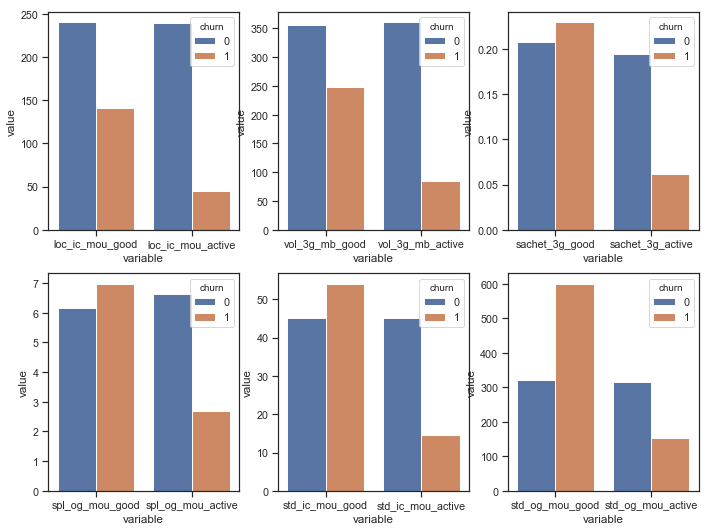

In [204]:
avg_bar_plot([('loc_ic_mou_good','loc_ic_mou_active'),
             ('vol_3g_mb_good','vol_3g_mb_active'),
             ('sachet_3g_good','sachet_3g_active'),
             ('spl_og_mou_good','spl_og_mou_active'),
             ('std_ic_mou_good','std_ic_mou_active'),('std_og_mou_good','std_og_mou_active')])

**Inference :**
 - A selection of the most prominent features have been analysed and visualised above. 
 - It is evident that the rate of decrease in the features - local incoming calls,special out-going calls,std calls are staunch indicators of churn behaviour.
 - This behaviour supports the analysis done in the exploratory stage
 - **NOTE:** Rest of the prominent features have been studied in Data Visualisation section.

### Stage 7 - Model Selection

                          Algorithm  Recall   F1  Accuracy
0   Logistic_Regression_Actual_Data    0.34 0.48      0.94
1         Logistic_Regression_SMOTE    0.81 0.41      0.82
2         Adaboost_Classifier_SMOTE    0.76 0.40      0.82
3        Logistic Regression ADASYN    0.86 0.35      0.75
4        Adaboost Classifier ADASYN    0.83 0.35      0.76
5      Logistic_Regression RUS Samp    0.79 0.39      0.81
6      Adaboost_Classifier RUS Samp    0.77 0.38      0.80
7        Simple Logistic Regression    0.86 0.35      0.75
8                    Logistic_Reg_P    0.86 0.35      0.75
9            Logistic_Regression_BW    0.81 0.41      0.81
10         Logistic_Regression_BW_P    0.81 0.41      0.81
11         Random_Forest_Classifier    0.58 0.48      0.90
12       Random_Forest_Classifier_T    0.72 0.46      0.87
13              Adaboost_Classifier    0.83 0.36      0.77
14         Logistic_Regression_BW_P    0.88 0.37      0.76


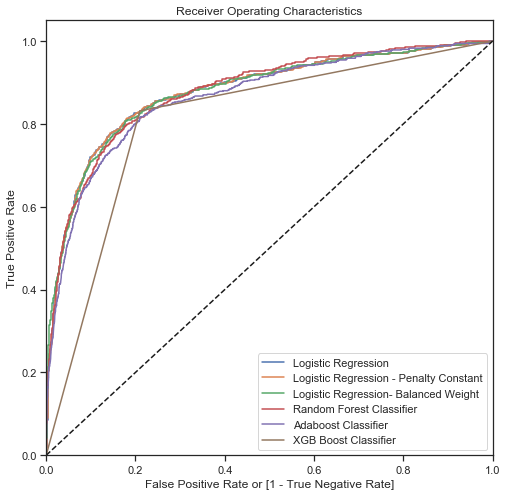

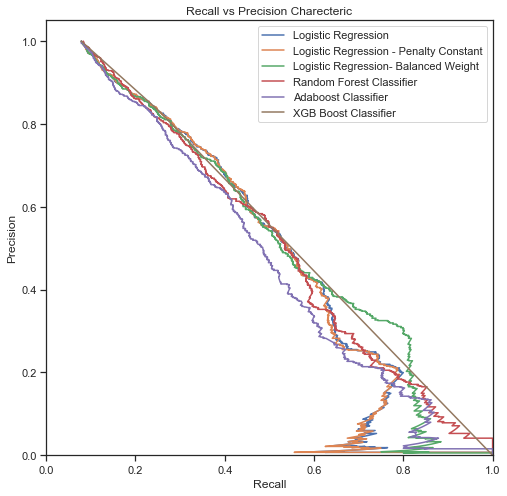

In [205]:
# Use the score_frame to draw consolidated ROC curve and Score matris to select the appropriate model

score_mat=pd.DataFrame(data={'Algorithm':algorithm_name,
      'Recall':recall_scores,
      'F1':f1_scores,
      'Accuracy':accuracy_scores})

print(score_mat)

cols=[('Test_Logrec','Prob_Logrec','Logistic Regression'),
      ('Test_Logrec_p','Prob_Logrec_p','Logistic Regression - Penalty Constant'),
      ('Test_Logrec_BW','Prob_Logrec_BW','Logistic Regression- Balanced Weight'),
      ('Test_RFC','Prob_RFC','Random Forest Classifier'),
      ('Test_ABC','Prob_ABC','Adaboost Classifier'),
      ('Test_XGBC','Prob_XGBC','XGB Boost Classifier')]

plt.figure(figsize=(8, 8))

for i in cols:
    fpr,tpr,threshold = roc_curve(score_frame[i[0]],score_frame[i[1]])
    plt.plot( fpr, tpr, label=i[2])


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc="lower right")

plt.show()

plt.figure(figsize=(8, 8))
for i in cols:
    precision, recall, threshold = precision_recall_curve(score_frame[i[0]],score_frame[i[1]])
    plt.plot( precision, recall, label=i[2])

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall vs Precision Charecteric')
plt.legend(loc="top left")
plt.show()

**Assumption:**
 - Assume that the business objective is to identify the High Value customer who will Churn. 
 - This implies that the measure of ability to correctly identify the churn customer should be higher.      

**Inference:**
 - Technically, the above measure translates to **Recall**
 - The model having higher Recall can be selected as a desired model. However, as the recall increases, the presicion/accurancy will decrease. 
 - Keeping the business goal in view, the accuracy will be traded off for a optimal recall. 
 - Please note that the **F1 Score** is the funciton of recall and precision, and a balanced F1 score will be considered for optimal Model.
 - From the above ROC curve, scores ,the Precesion vs Recall curve, the model **Logistic_Regression_BW_P** is being selected - A Logistic Regression with Penalty and balanced weights.

y_train Adaptive Over Sampling Mean:  0.49867422750781026 

Logistic_Regression_BW_P : 
-------------------------
Classification report :  
               precision    recall  f1-score   support

         0.0       0.99      0.75      0.85      8225
         1.0       0.23      0.88      0.37       701

   micro avg       0.76      0.76      0.76      8926
   macro avg       0.61      0.82      0.61      8926
weighted avg       0.93      0.76      0.82      8926

Accuracy   Score :  0.7638359847636119
Recall Score on train Set:  0.8246907080810739
Recall Score on test Set:  0.8758915834522111
Area under curve :  0.8150886488689626 

Confusion Matrix:  
 [[6204 2021]
 [  87  614]]


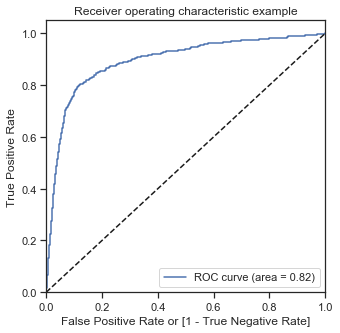

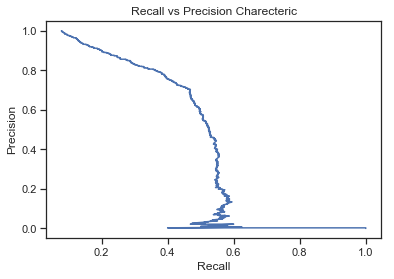

In [206]:
# Rerun the selected model with Prominent features

a=x_train[prom_f]
b=x_test[prom_f]
asmt = ADASYN(random_state = 42)
x_train_asmt, y_train_asmt = asmt.fit_sample(a, y_train)
print('y_train Adaptive Over Sampling Mean: ',y_train_asmt.mean(),"\n")
    
# Set the train and test data
x_train_samp = pd.DataFrame(data=x_train_asmt,columns=prom_f)
y_train_samp= pd.DataFrame(data=y_train_asmt,columns=['churn'])

# Run Logistic Regression with Balanced Weights
y_test,y_pred=run_algorithm(logreg_bal_p,x_train_samp,y_train_samp,b,y_test,'Logistic_Regression_BW_P','y')
precision, recall, threshold = precision_recall_curve(y_test,y_pred)
plt.plot( precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall vs Precision Charecteric')
plt.show()

### Stage 8 - Conclusion

The Top 5 prominent features to determine the customer churn behaviour are - 
 - The sudden surge in the special incoming and out going calls in the Active months
 - Considerable reduction in the std incoming and out going calls
 - Sudden reduction in the usage of 3g data services
 - Sudden drop in the local incoming calls. ( The contact preferences of the customer changing)
 - Sudden reduction in the usage of services with validity less than a month - for example 3g Sachets
 - It is also evident from Exploratory Data Analysis, that where the data is not collected ( NaNs), the percentage of Churn is higher.The KPI data collection methods will need to be reviewed for a better prediction.
    